In [1]:
import pickle
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from utils.history_buffer import HistoryBuffer

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("dataset/eComm-sample-data2.csv", usecols=['product_id_num', 'price'])
df.drop_duplicates(subset=['product_id_num'], inplace=True, ignore_index=True)

In [4]:
data_df = pd.read_csv('dataset/eComm-sample-data2.csv')
event_type_to_num = {'view': 1, 'cart': 2, 'purchase': 3}
data_df['behavior'] = data_df['event_type'].apply(lambda x : event_type_to_num[x])
data = data_df.loc[:, ['user_id_num', 'product_id_num', 'behavior', 'event_time']].values

In [5]:
state_rep_net = DRRAveStateRepresentation(n_items=5, item_features=100, user_features=100)
actor_net = Actor(in_features=300, out_features=100)

In [6]:
state_rep_net.load_state_dict(torch.load('results/220623-075948/state_rep_net.weights'))

<All keys matched successfully>

In [7]:
actor_net.load_state_dict(torch.load('results/220623-075948/actor_net.weights'))

<All keys matched successfully>

In [8]:
NUM_USERS, NUM_ITEMS = 5309, 15184
embedding_feature_size = 100
path_to_trained_pmf = 'trained/eComm_ratio_0.800000_bs_256_e_25_wd_0.100000_lr_0.000100_trained_pmf.pt'
device = torch.device('cpu')

In [9]:
# Create and load PMF function for rewards and embeddings
reward_function = PMF(NUM_USERS, NUM_ITEMS, embedding_feature_size, is_sparse=False, no_cuda=True)
reward_function.load_state_dict(torch.load(path_to_trained_pmf))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)

Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([5309, 100])
Item embeddings shape:  torch.Size([15184, 100])


In [10]:
cuda = False

def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)
    
seed_all(cuda, 0)

In [11]:
data_df = pd.read_csv('dataset/eComm-sample-data2.csv')
event_type_to_num = {'view': 1, 'cart': 2, 'purchase': 3}
data_df['behavior'] = data_df['event_type'].apply(lambda x : event_type_to_num[x])

items = dict(zip(data_df['product_id'], data_df['product_id_num']))
users = dict(zip(data_df['user_id'], data_df['user_id_num']))

NUM_USERS, NUM_ITEMS = len(users), len(items)
print(NUM_USERS, NUM_ITEMS)

data = data_df.loc[:, ['user_id_num', 'product_id_num', 'behavior', 'event_time']].values

np.random.shuffle(data)
train_data = torch.from_numpy(data[:int(0.8 * data.shape[0])])
test_data = torch.from_numpy(data[int(0.8 * data.shape[0]):])
print("Data imported, shuffled, and split into Train/Test, ratio=", 0.8)
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)


5309 15184
Data imported, shuffled, and split into Train/Test, ratio= 0.8
Train data shape:  torch.Size([100427, 4])
Test data shape:  torch.Size([25107, 4])


In [12]:
device = torch.device('cpu')

In [13]:
test_data = test_data.to(device)

In [14]:
user_idxs = np.unique(test_data[:, 0].numpy())

In [15]:
np.random.shuffle(user_idxs)

In [16]:
candidate_item_idxs = np.arange(item_embeddings.shape[0])
candidate_item_idxs = torch.from_numpy(candidate_item_idxs).to(device).long()

In [17]:
user_id_history_lens = {user_id : test_data[test_data[:, 0]==user_id] for user_id in user_idxs}

In [18]:
user_id_history_lens = {k : v[v[:, 3].sort(descending=True)[1]] for k, v in user_id_history_lens.items()}

In [19]:
sample_user_idx = []
for k, v in user_id_history_lens.items():
    if (list(v[:, 2]).count(3) == 2):
        sample_user_idx.append(k)
print(len(sample_user_idx))

208


In [21]:
sample_user_idx = random.sample(sample_user_idx, 25)

In [22]:
user_id_history_lens_sample = {k: v for k, v in user_id_history_lens.items() if k in sample_user_idx}

In [23]:
def discretize_reward_(x):
    x = x.item()
    if x<=1:
        return torch.tensor(1.0, dtype=torch.float64)
    elif x<=2:
        return torch.tensor(2.0, dtype=torch.float64)
    else:
        return torch.tensor(3.0, dtype=torch.float64)

In [24]:
def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

In [25]:
eps_eval = 0.1
history_buffer_size = 5
history_buffer = HistoryBuffer(5)

In [26]:
precision = []
ndcg = []
mean_rewards = []
x = [*range(1, 11)]

for T in range(1, 11):
    mean_ndcg, mean_precision, steps = 0, 0, 0 
    
    r = 0
    
    for index, e in enumerate(user_idxs):
        
        # extract user reviews and positive user reviews for user id
        user_reviews = test_data[test_data[:, 0] == e]
        pos_user_reviews = user_reviews[user_reviews[:, 2] > 0]

        # history should be sufficient
        if pos_user_reviews.shape[0] < history_buffer_size:
            continue
            
        steps += 1    
        # sort user history by timestamp
        user_reviews = user_reviews[user_reviews[:, 3].sort(descending=True)[1]]
        pos_user_reviews = pos_user_reviews[pos_user_reviews[:, 3].sort(descending=True)[1]]

        # canditate items embedding for recommendation
        candidate_items = item_embeddings.detach().clone().to(device)

        # get user embedding
        user_emb = user_embeddings[e]
        
        history_buffer.clear()
        
        # fill up history buffer
        for i in range(history_buffer_size):
            emb = candidate_items[pos_user_reviews[i, 1]]
            history_buffer.push(emb.detach().clone())

        # get action
        with torch.no_grad():
            # use state rep net weights to get state (input args is user embedding and history buffer)
            state = state_rep_net(user_emb, torch.stack(history_buffer.to_list()))
            
            if np.random.uniform(0, 1) < eps_eval:
                action = torch.from_numpy(0.1 * np.random.rand(100)).float().to(device)
            else:
                action = actor_net(state.detach())
            

        # matmul for ranking scores
        ranking_scores = candidate_items @ action

        # get top T item indices
        values, indices = torch.topk(ranking_scores, T)
        
        # calculate reward for predictions
        rewards = [reward_function(torch.tensor(e).to(device) ,rec_item_index) for rec_item_index in indices]
        rewards = [discretize_reward_(reward).item() for reward in rewards]
        
        r += np.mean(rewards)

        correct_list = [1 if r ==3.0 else 0 for r in rewards]
        dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(rewards))])
        mean_ndcg += dcg/idcg
        
        correct_num = T-correct_list.count(0)
      
        mean_precision += correct_num/T
    
    precision.append(mean_precision/steps)
    ndcg.append(mean_ndcg/steps)
    mean_rewards.append(r/steps)
        
    print(f"T {T} mean precision {(mean_precision/steps):.2f}, mean_ndcg {(mean_ndcg/steps):.2f}, avg reward {(r/steps):.2f} total steps/users {steps}")

/Users/ankurdhuriya/miniconda3/envs/drr_pytorch/lib/python3.10/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


T 1 mean precision 0.39, mean_ndcg 0.39, avg reward 2.39 total steps/users 1791
T 2 mean precision 0.37, mean_ndcg 0.38, avg reward 2.37 total steps/users 1791
T 3 mean precision 0.40, mean_ndcg 0.40, avg reward 2.40 total steps/users 1791
T 4 mean precision 0.41, mean_ndcg 0.40, avg reward 2.41 total steps/users 1791
T 5 mean precision 0.40, mean_ndcg 0.39, avg reward 2.40 total steps/users 1791
T 6 mean precision 0.38, mean_ndcg 0.39, avg reward 2.38 total steps/users 1791
T 7 mean precision 0.39, mean_ndcg 0.39, avg reward 2.39 total steps/users 1791
T 8 mean precision 0.39, mean_ndcg 0.39, avg reward 2.39 total steps/users 1791
T 9 mean precision 0.39, mean_ndcg 0.39, avg reward 2.39 total steps/users 1791
T 10 mean precision 0.39, mean_ndcg 0.39, avg reward 2.39 total steps/users 1791


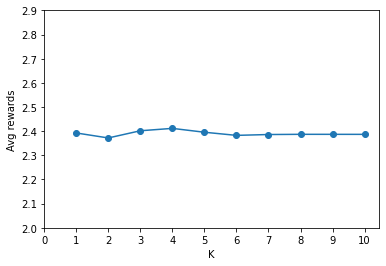

In [32]:
plt.plot([*range(1, 11)], mean_rewards, marker='o')
plt.yticks(np.arange(2, 3, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.xlabel("K")
plt.ylabel("Avg rewards")
plt.savefig("Average rewards vs K")
plt.show()

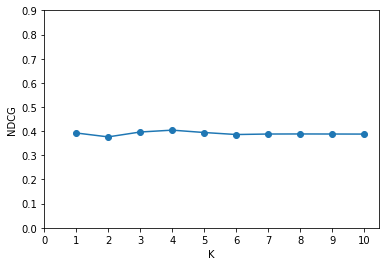

In [33]:
plt.plot([*range(1, 11)], ndcg, marker='o')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.xlabel("K")
plt.ylabel("NDCG")
plt.savefig("NDCG vs K")
plt.show()

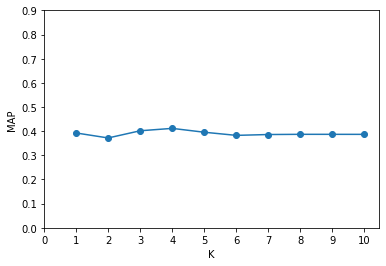

In [34]:
plt.plot([*range(1, 11)], precision, marker='o')
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.xlabel("K")
plt.ylabel("MAP")
plt.savefig("MAP vs K")
plt.show()

In [30]:
def calc_cos_similarity(a, b, eps=1e-6):
    """
    added eps for numerical stability
    """
    a = candidate_items[a]
    b = candidate_items[b]
    
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [39]:
eps_eval = 0.1
history_buffer_size = 5
history_buffer = HistoryBuffer(5)
T = 2

candidate_items = item_embeddings.detach().clone().to(device)

similarity = {}

price_before, price_after = [], []

for user_id, history in user_id_history_lens_sample.items():
    pos_user_reviews = history
    user_emb = user_embeddings[user_id]
    
    recent_two_purchased_items = torch.unique(history[history[:, 2]==3][:, 1])[:2]
    avg_price_before = sum([df[df.product_id_num==i.item()].price.values[0] for i in recent_two_purchased_items])/2
    price_before.append(avg_price_before)

    history_buffer.clear()
        
    # fill up history buffer
    for i in range(history_buffer_size):
        emb = candidate_items[pos_user_reviews[i, 1]]
        history_buffer.push(emb.detach().clone())
        
    # get action
    with torch.no_grad():
        # use state rep net weights to get state (input args is user embedding and history buffer)
        state = state_rep_net(user_emb, torch.stack(history_buffer.to_list()))

        if np.random.uniform(0, 1) < eps_eval:
            action = torch.from_numpy(0.1 * np.random.rand(100)).float().to(device)
        else:
            action = actor_net(state.detach())

    # matmul for ranking scores
    ranking_scores = candidate_items @ action

    # get top T item indices
    values, indices = torch.topk(ranking_scores, T)
    
    mat = calc_cos_similarity(recent_two_purchased_items, indices)
    
    similarity[user_id] = {'recent_item': recent_two_purchased_items, 'rec_item': indices, 'mat': mat}

    # calculate reward for predictions
    rewards = [reward_function(torch.tensor(user_id).to(device), rec_item_index) for rec_item_index in indices]

    rewards = [discretize_reward_(reward).item() for reward in rewards]
    
    correct_list = [1 if r ==3.0 else 0 for r in rewards]
    
    
    avg_price_now = sum([df[df.product_id_num==indices[i].item()].price.values[0] for i, reward in enumerate(rewards) if reward==3.0]) / 2
    price_after.append(avg_price_now)
    
    dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(rewards))])
    ndcg = dcg/idcg

    correct_num = T-correct_list.count(0)

    precision = correct_num/T
    
    # print(user_id, avg_price_before, avg_price_now)
    # print(f"user_id {user_id} rec_items {indices} precision {(precision):.2f}, ndcg {(ndcg):.2f}")

In [40]:
sum(price_before)/100, sum(price_after)/100

(450.5355000000001, 327.4352499999999)

In [26]:
import pickle

In [27]:
with open('cos_similarity.pkl', 'wb') as fp:
    pickle.dump(similarity, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('cos_similarity.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [29]:
type(data)

dict

In [30]:
len(data.keys())

25

In [31]:
import matplotlib.pyplot as plt

In [32]:
data.keys()

dict_keys([1175, 2274, 4482, 3912, 280, 550, 3462, 65, 1873, 5199, 1312, 4988, 356, 4288, 4268, 3582, 5289, 4049, 4083, 4982, 3613, 5153, 4478, 2021, 3085])

In [33]:
def plot_table(user_id):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    plt.axis('off')
    plt.axis('tight')

    the_table = ax.table(cellText=data[user_id]['mat'].tolist(), 
             colLabels=data[user_id]['rec_item'].tolist(), 
             rowLabels = data[user_id]['recent_item'].tolist(), 
             loc='bottom')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(50)
    the_table.scale(12, 16)

    fig.tight_layout()

    plt.show()


	user_id : 1175


/var/folders/g7/66p63lnn5_55gcwkh8g9n2fm0000gp/T/ipykernel_889/732733699.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


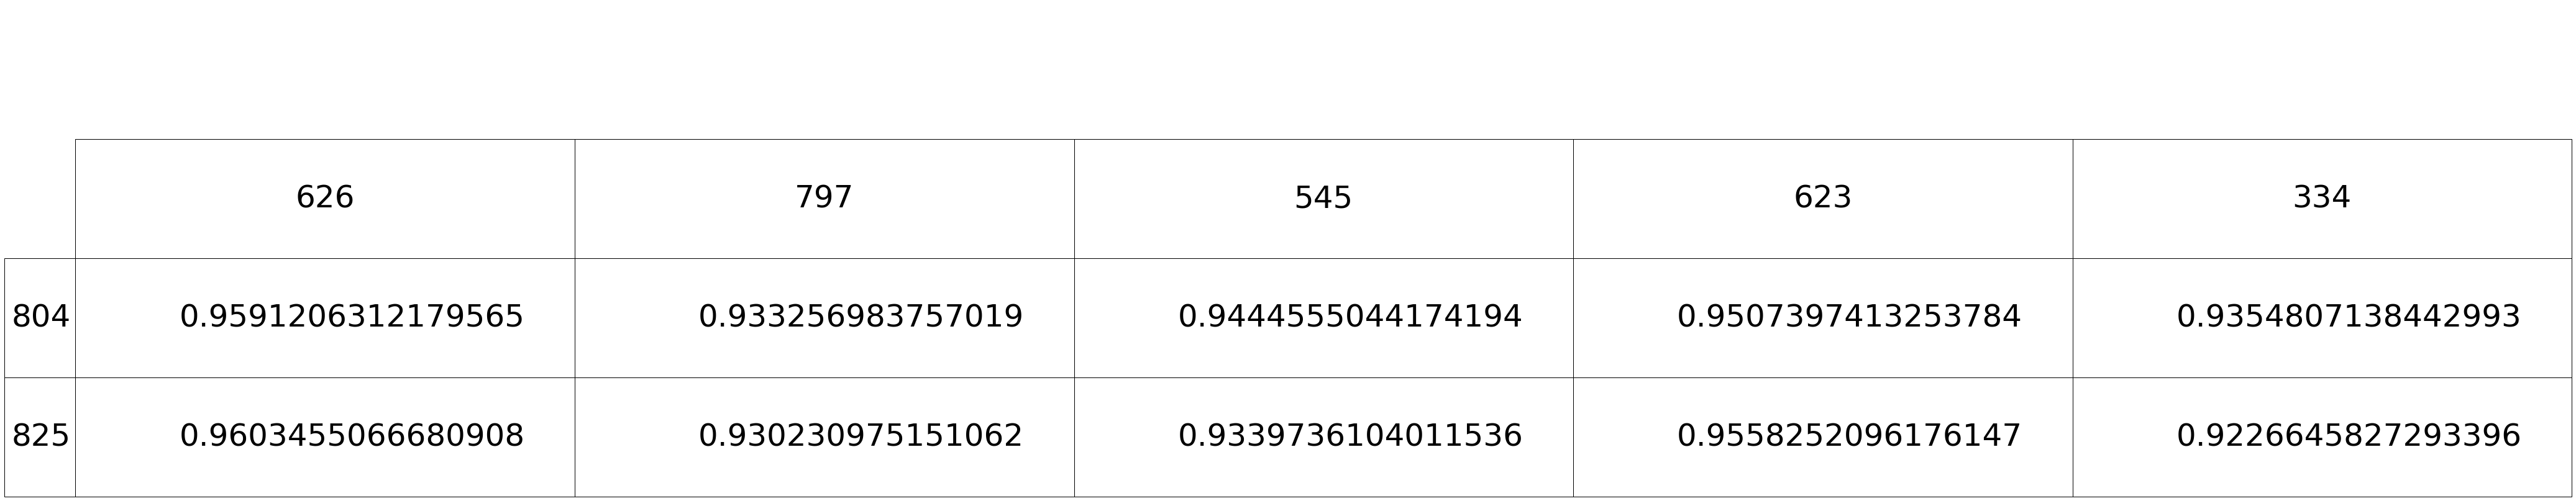


	user_id : 2274


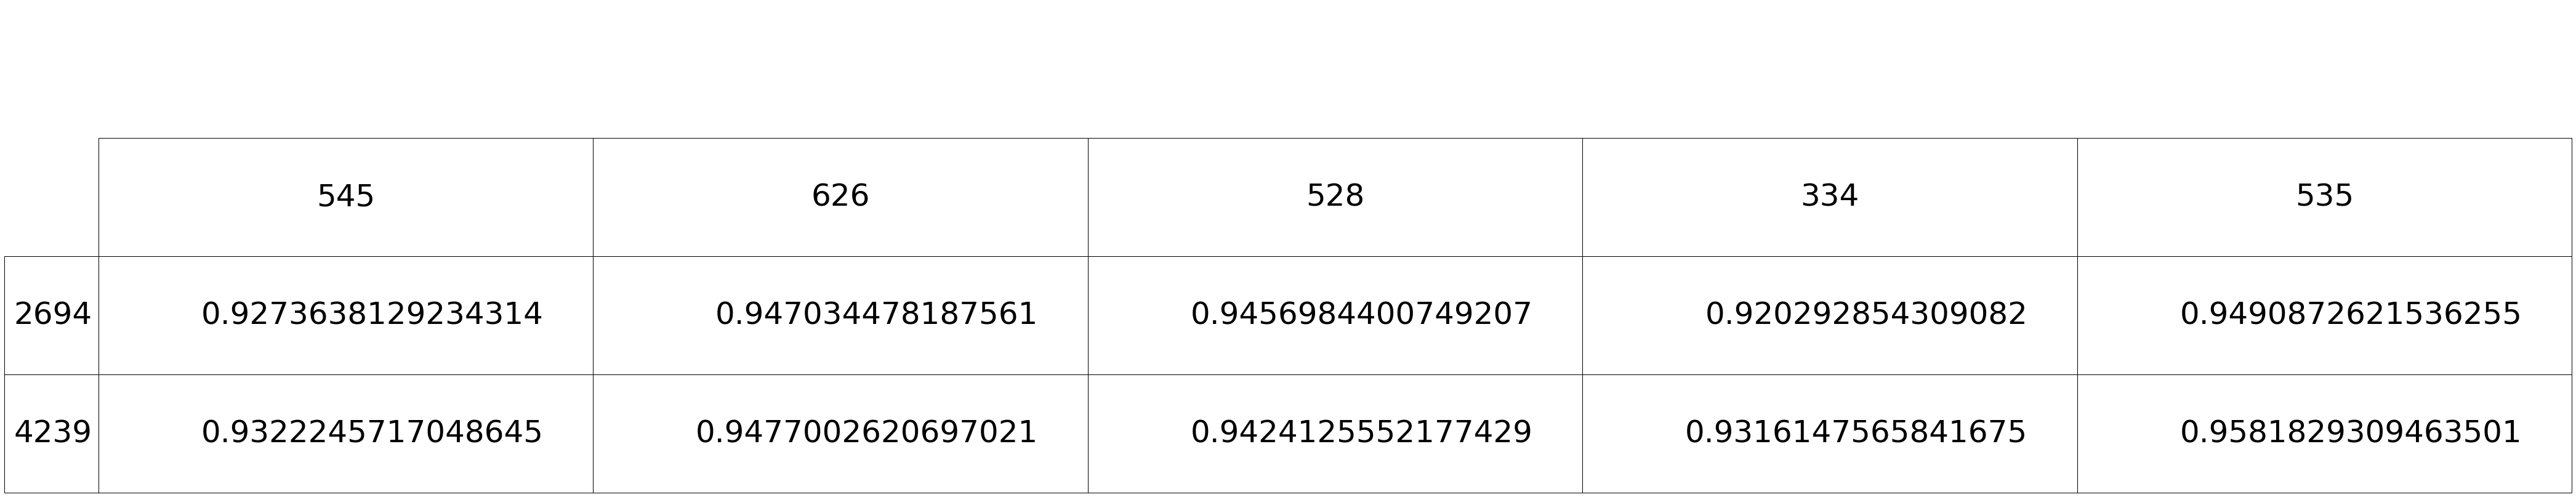


	user_id : 4482


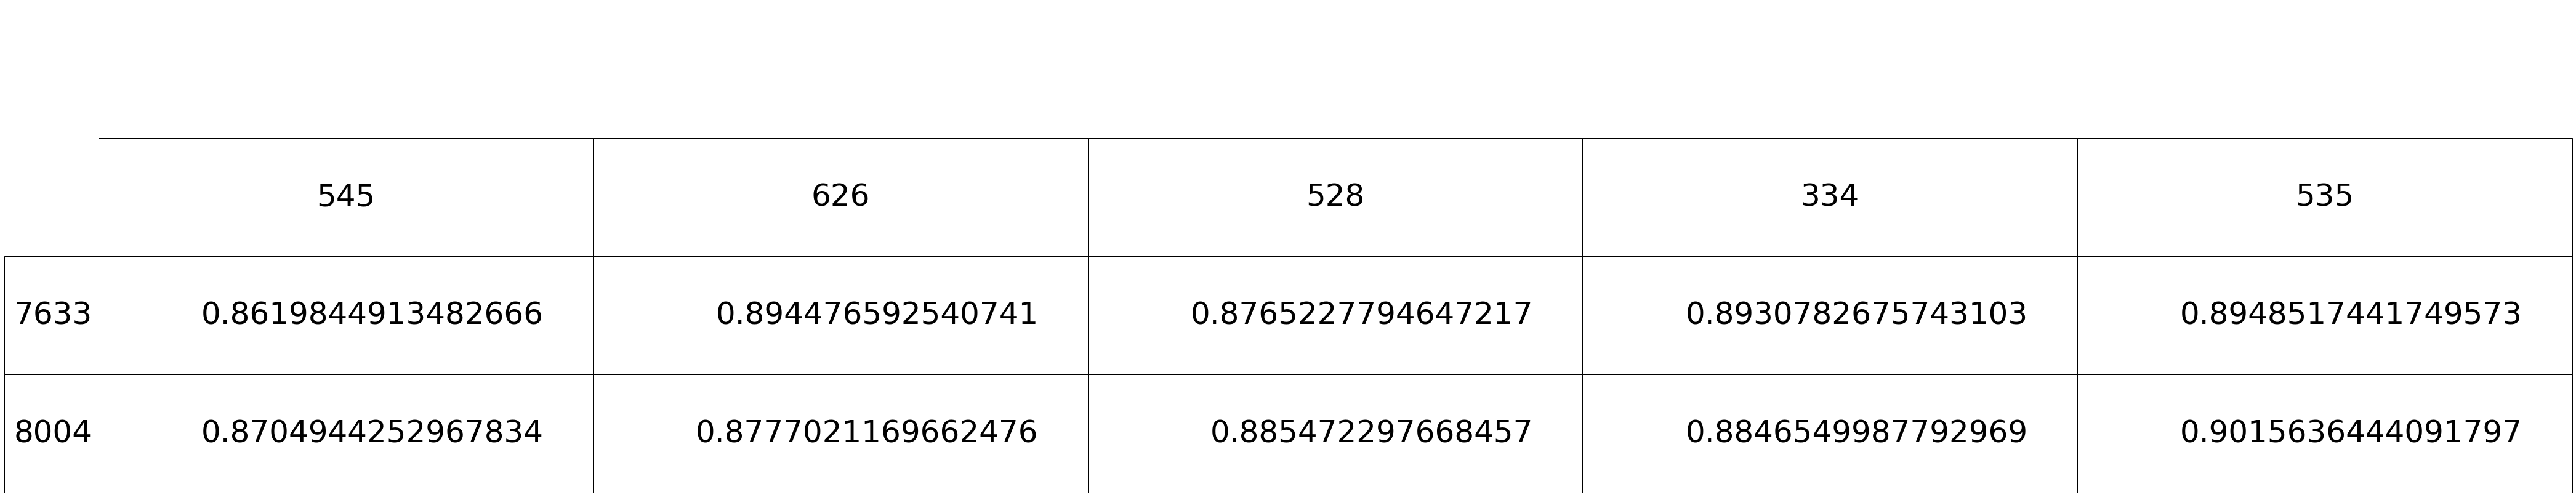


	user_id : 3912


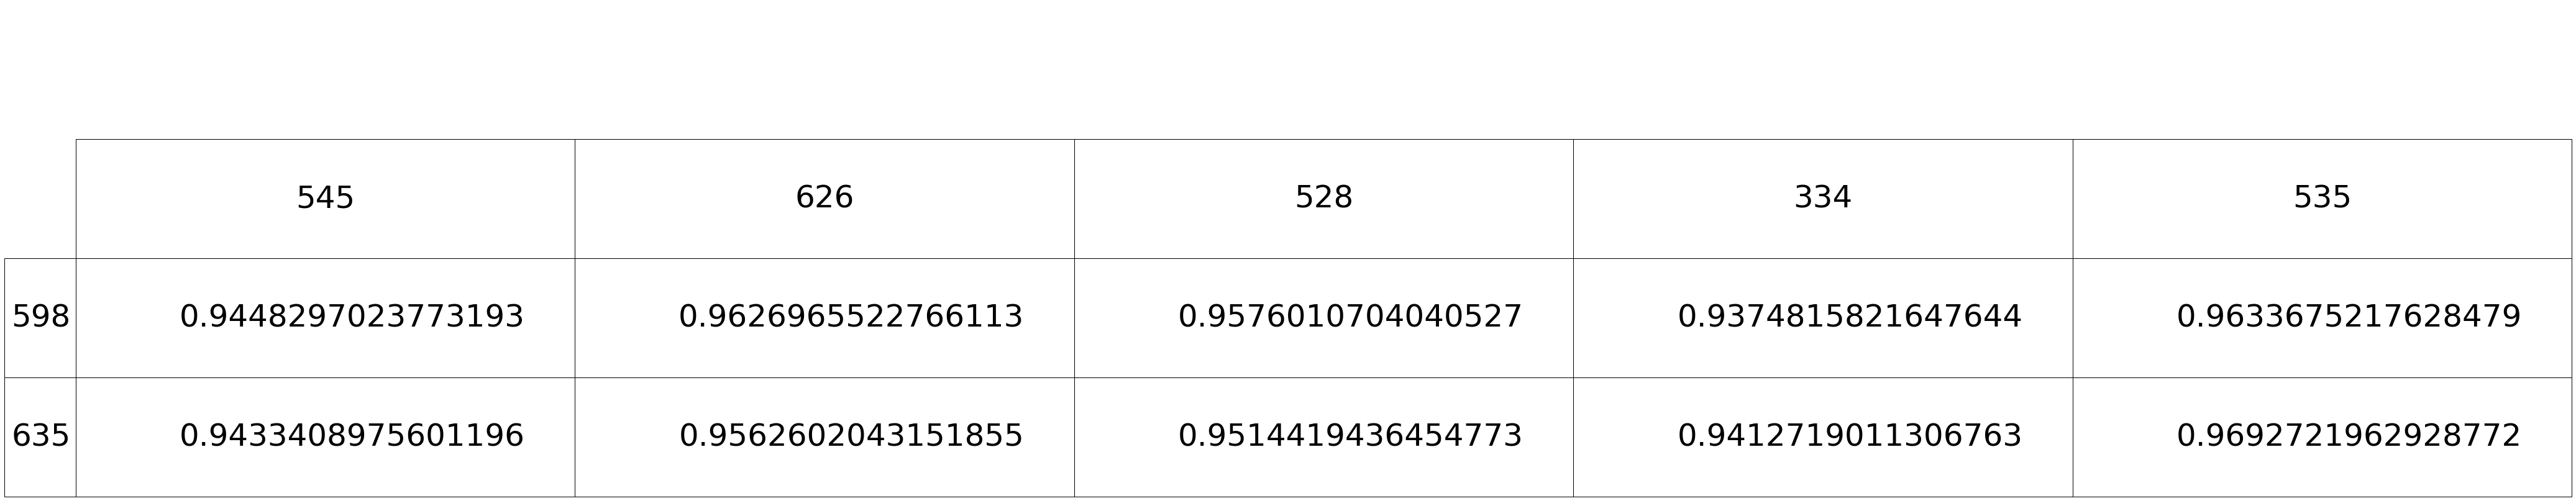


	user_id : 280


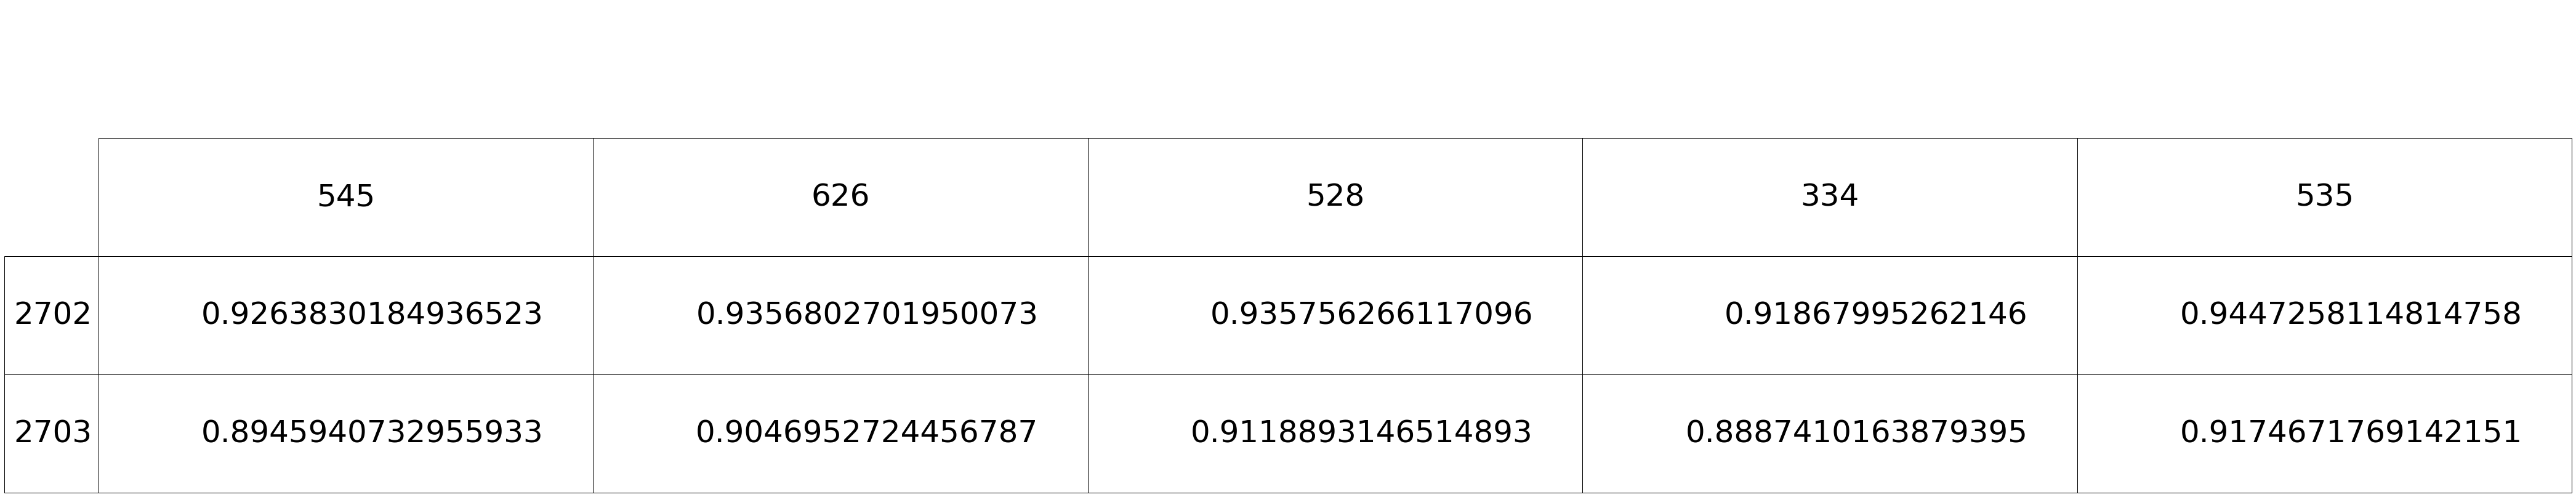


	user_id : 550


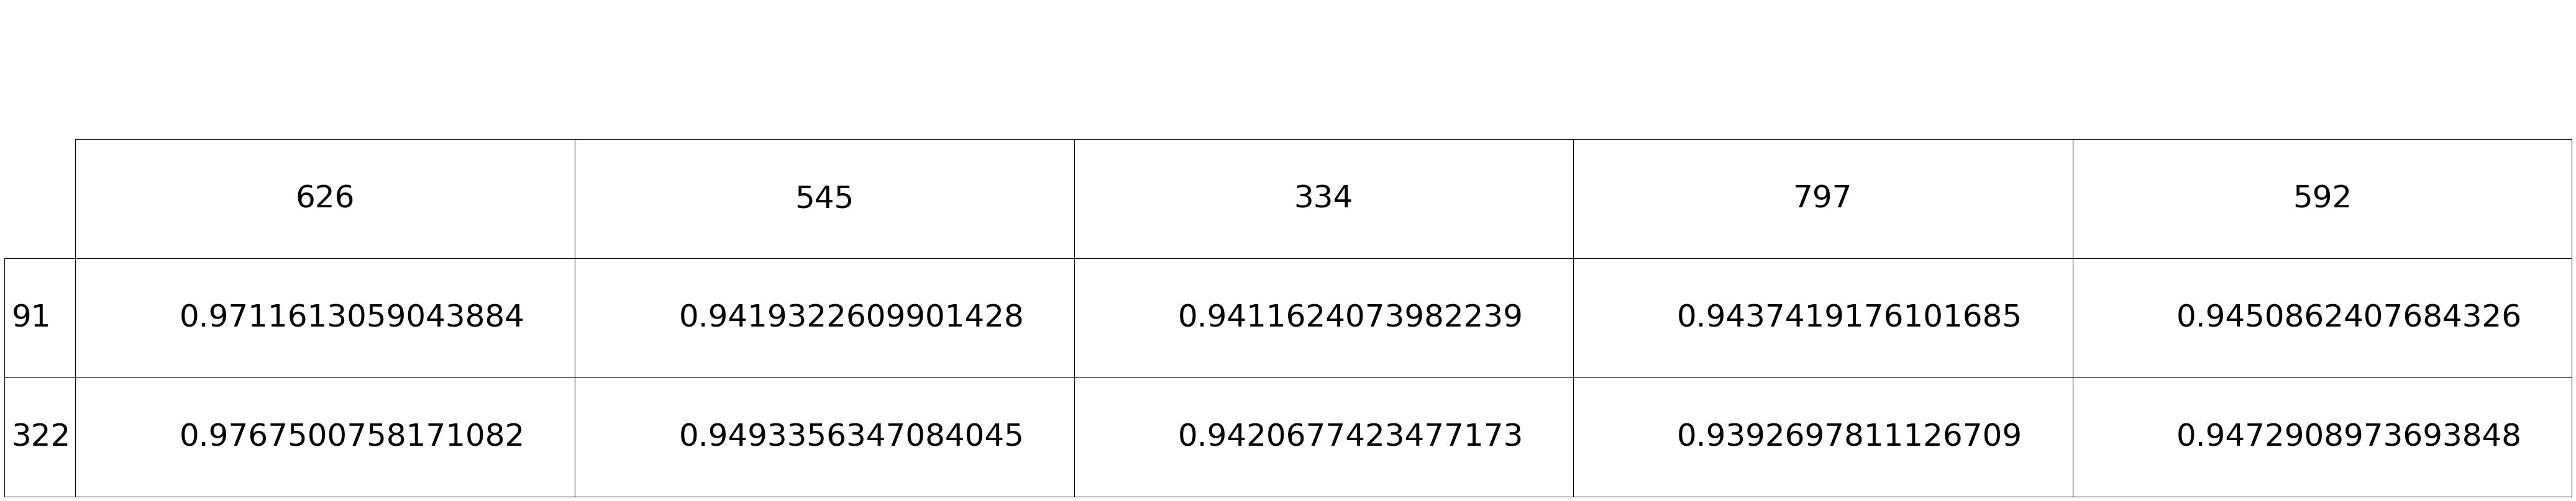


	user_id : 3462


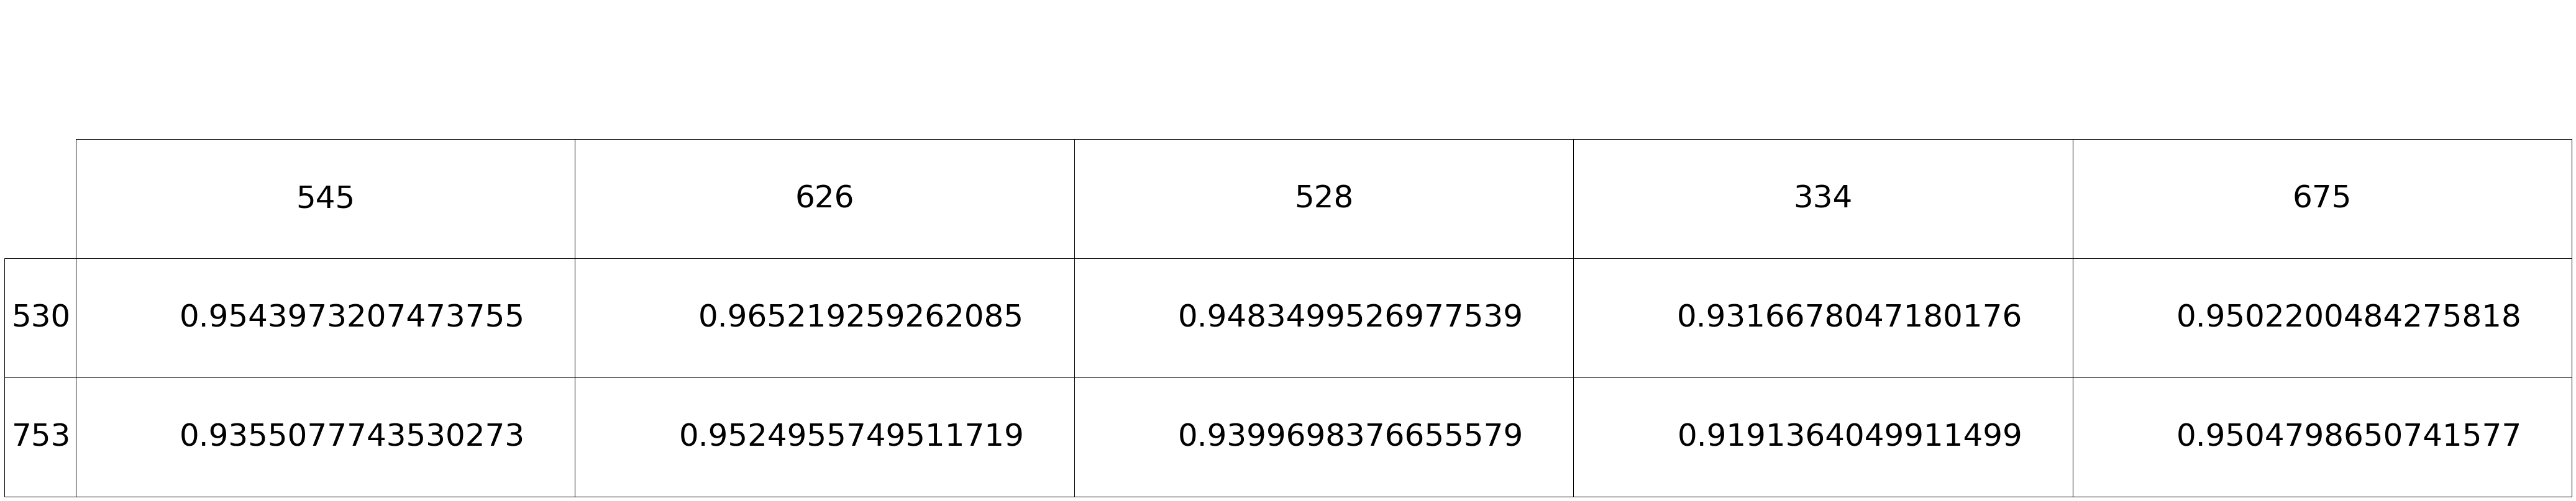


	user_id : 65


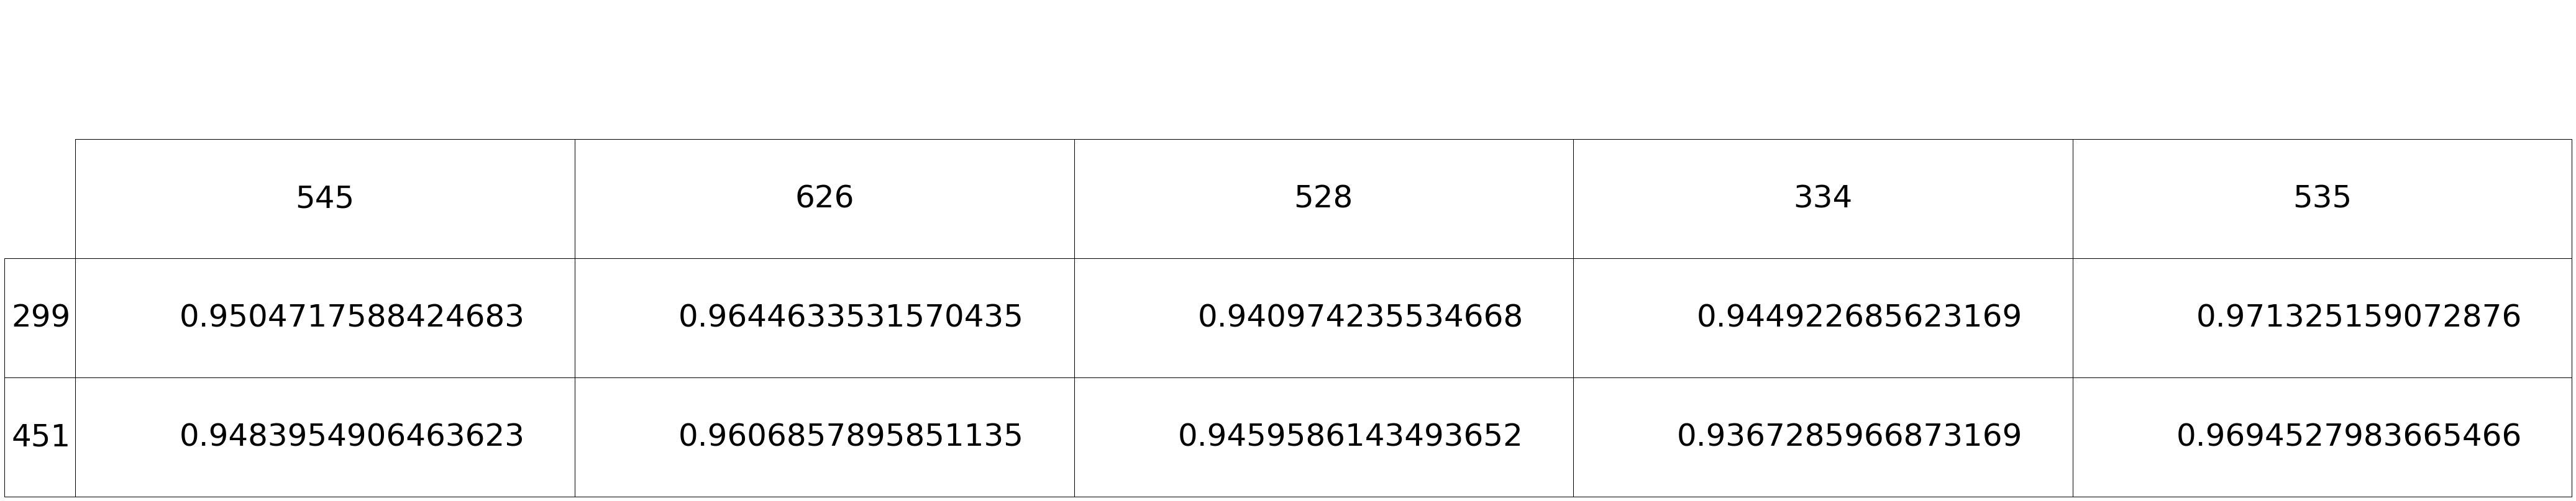


	user_id : 1873


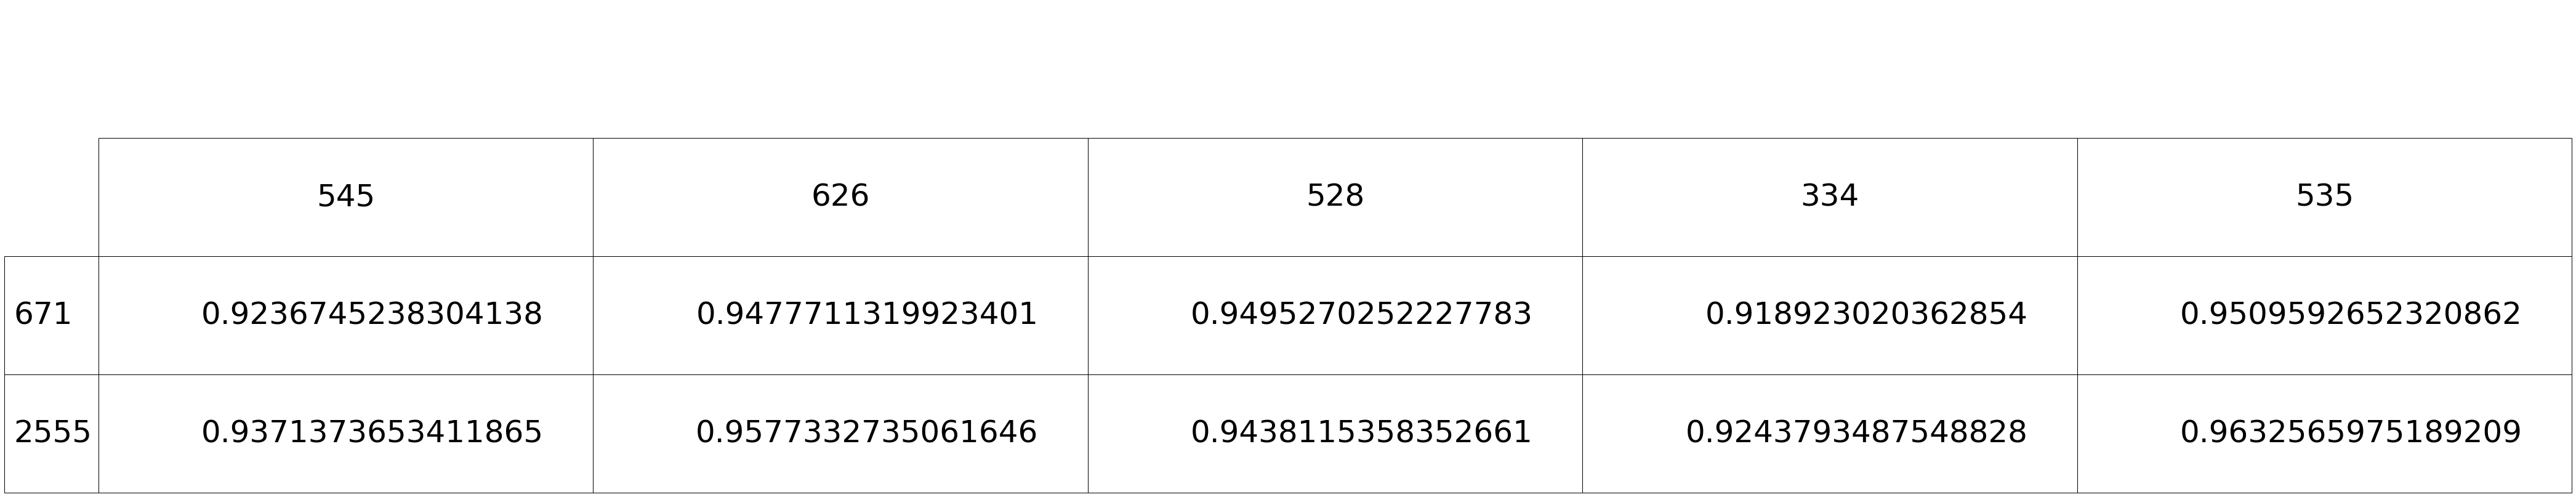


	user_id : 5199


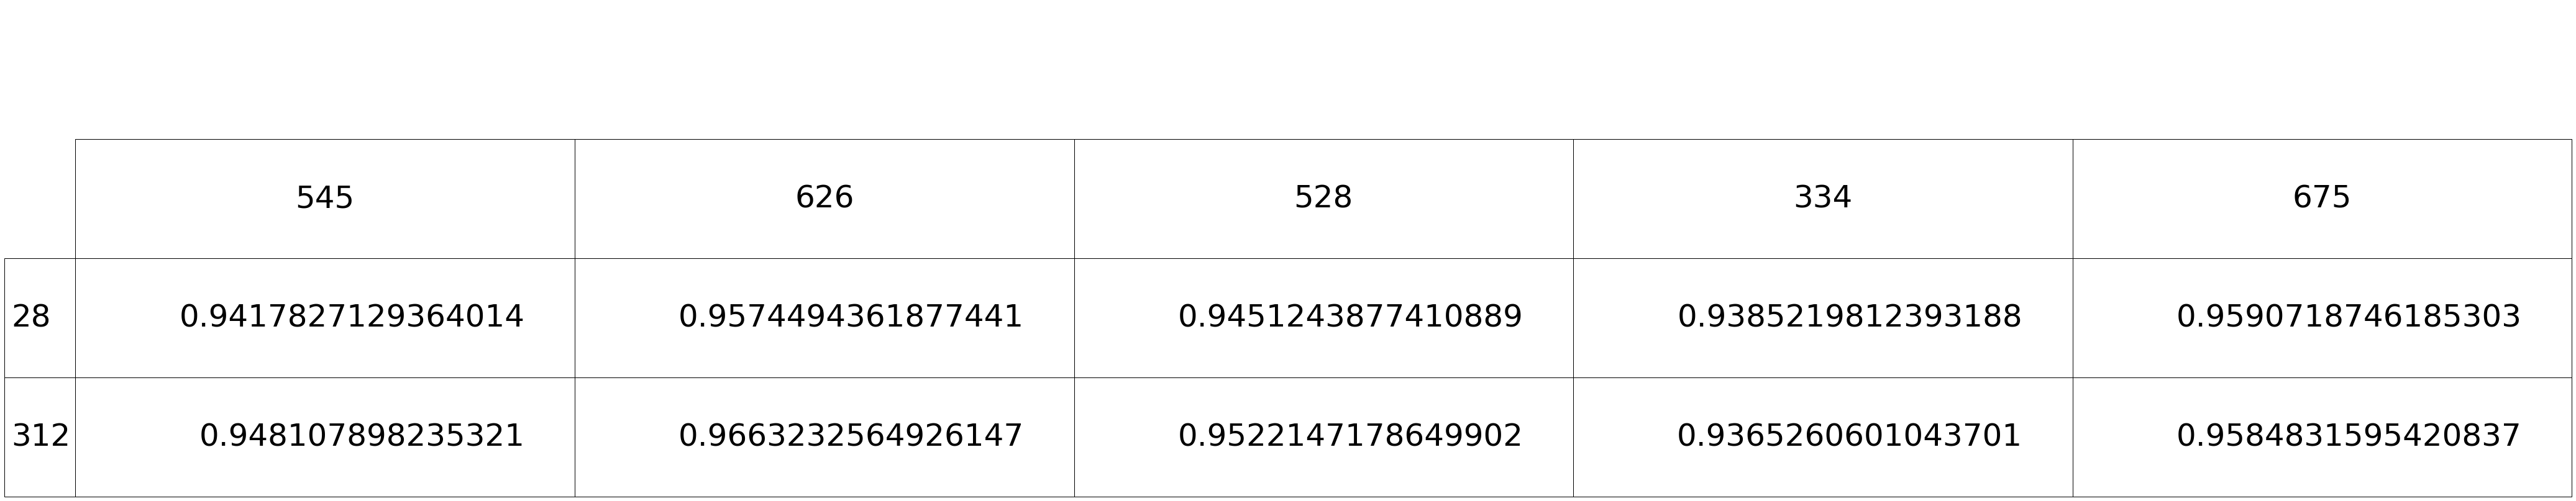


	user_id : 1312


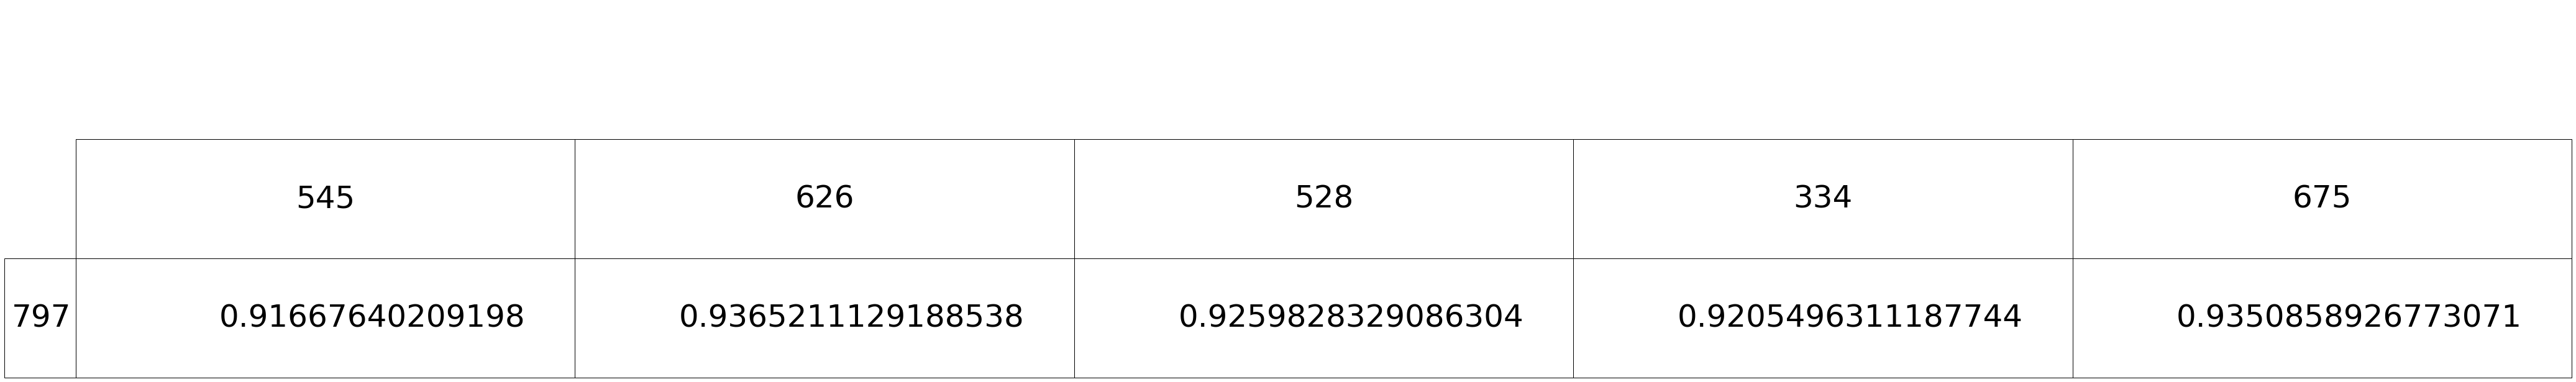


	user_id : 4988


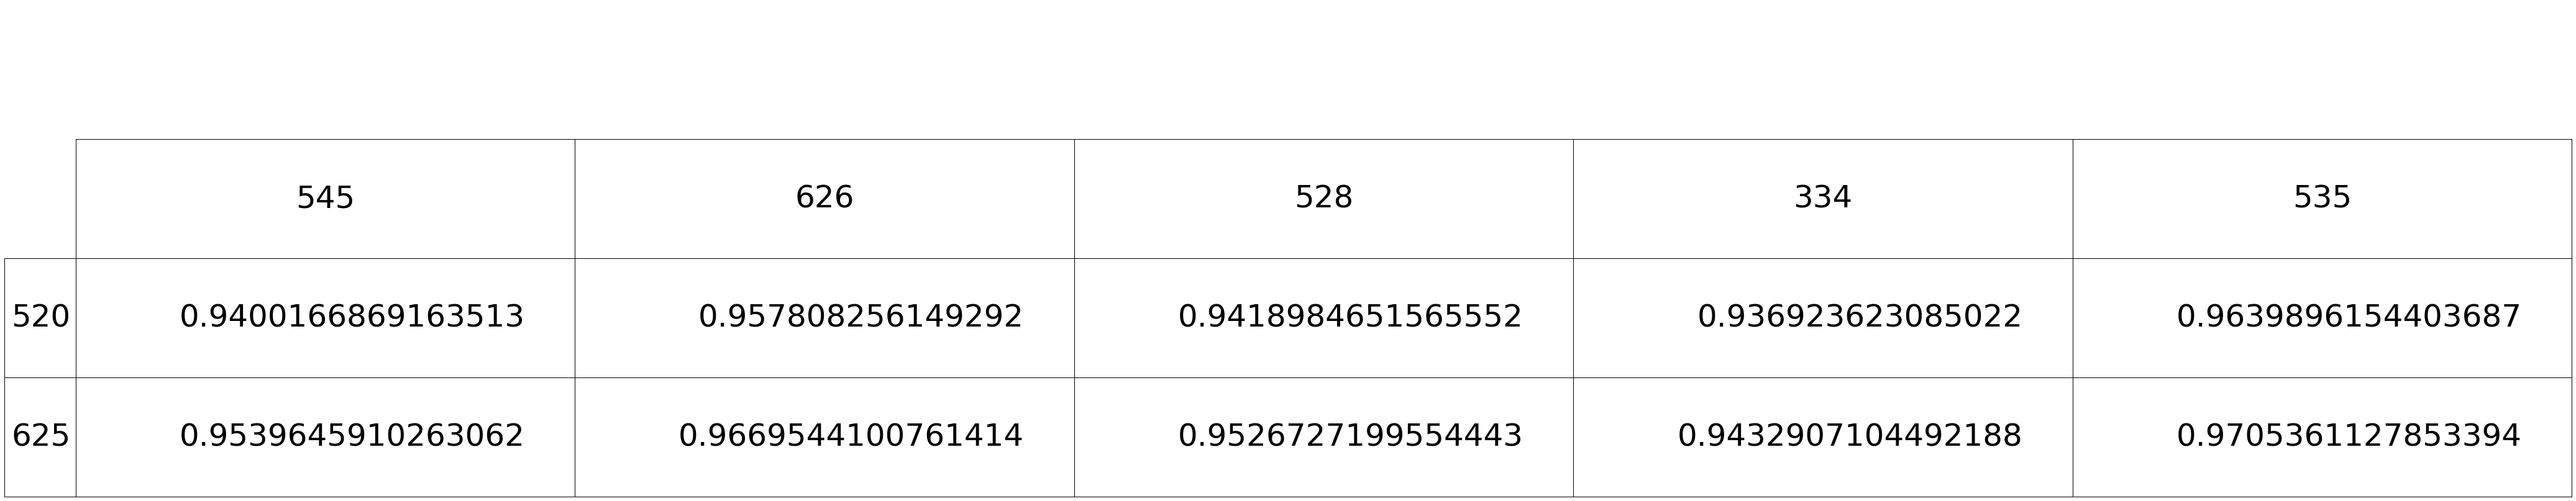


	user_id : 356


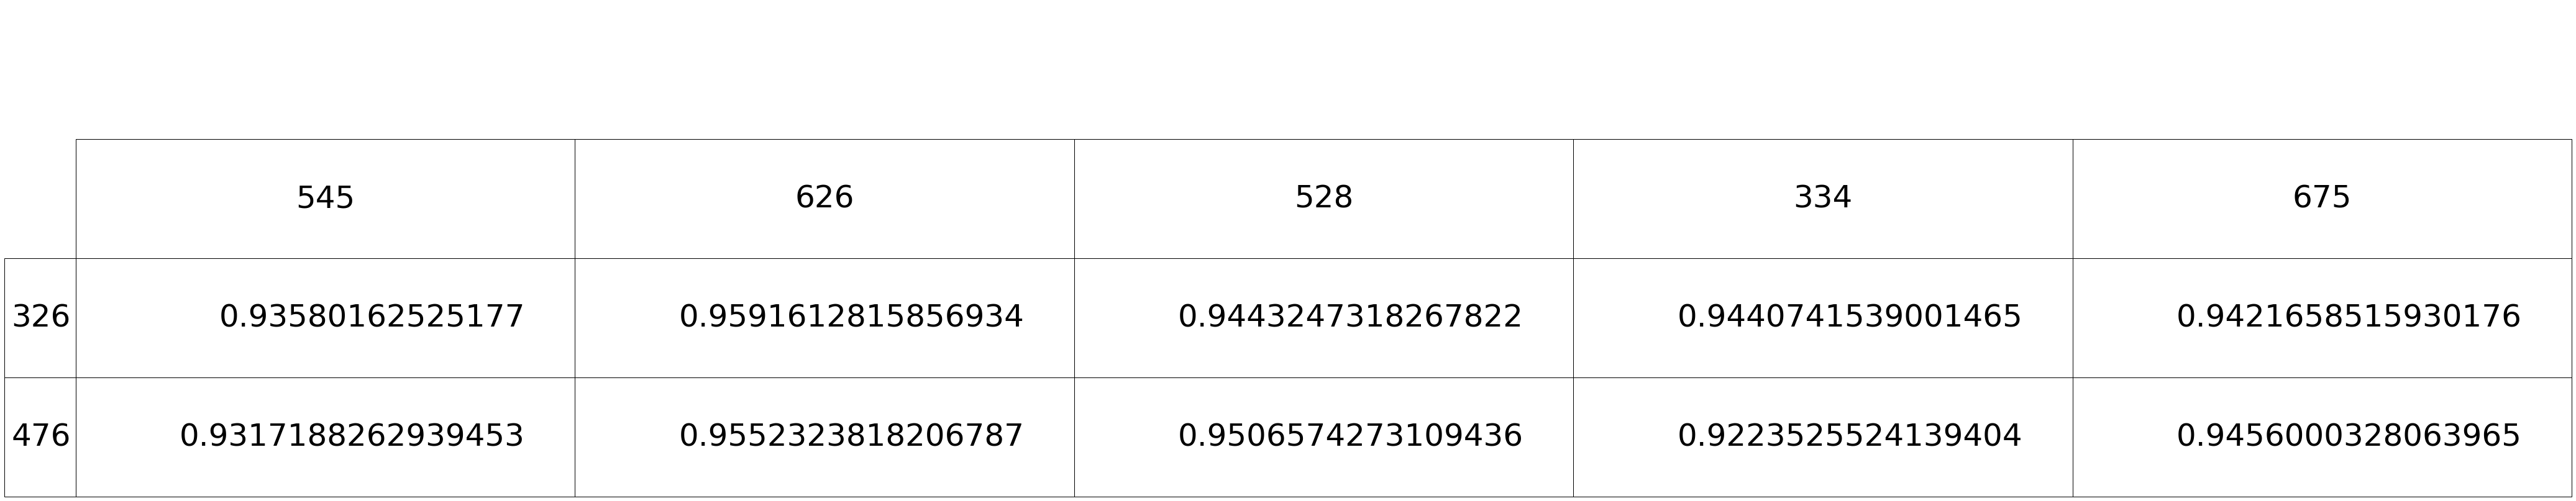


	user_id : 4288


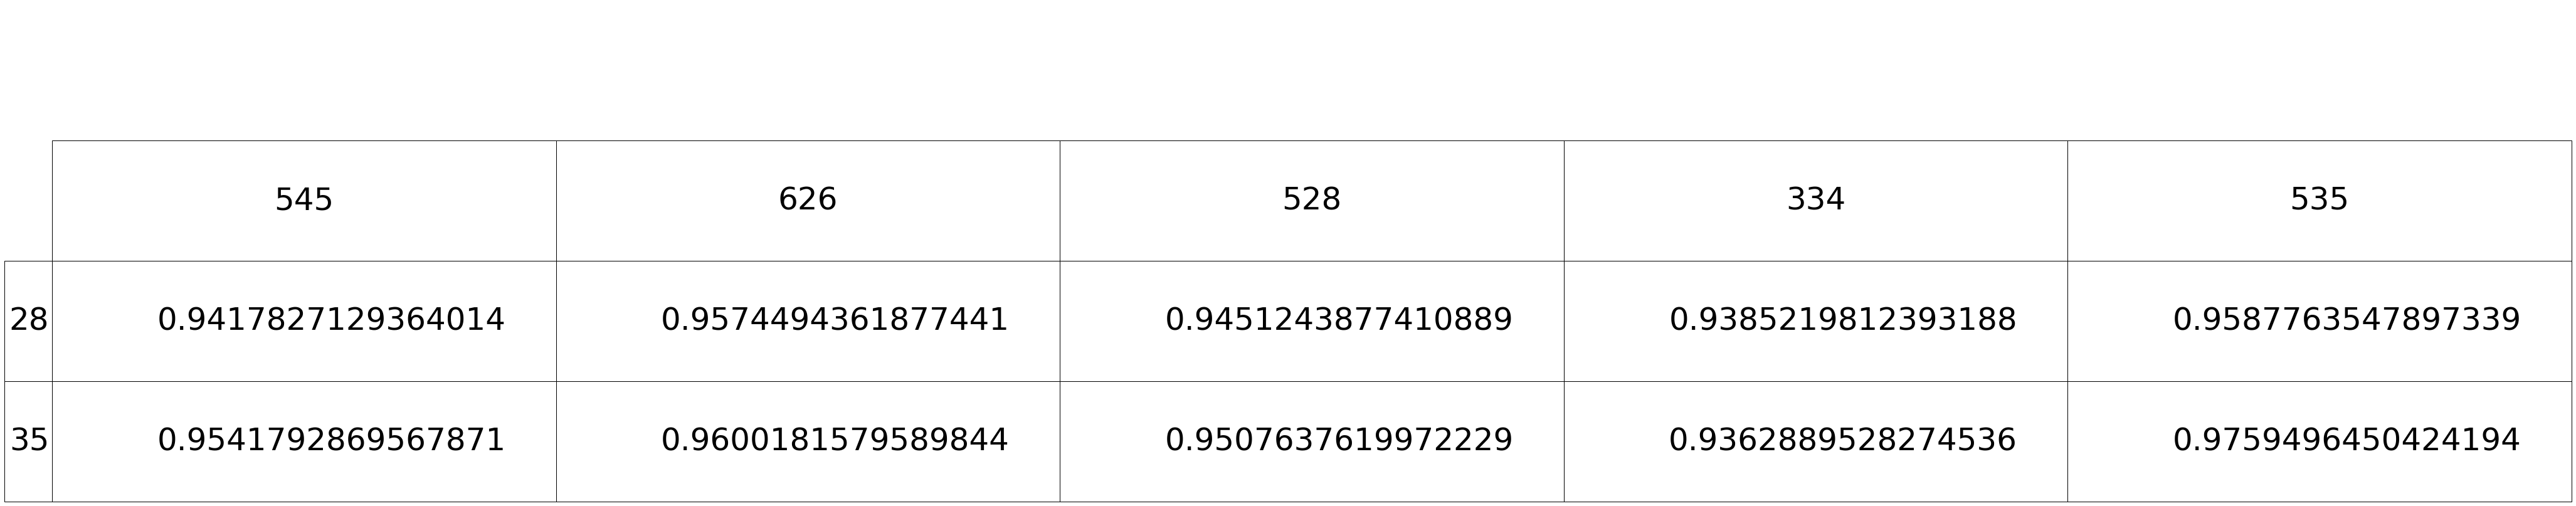


	user_id : 4268


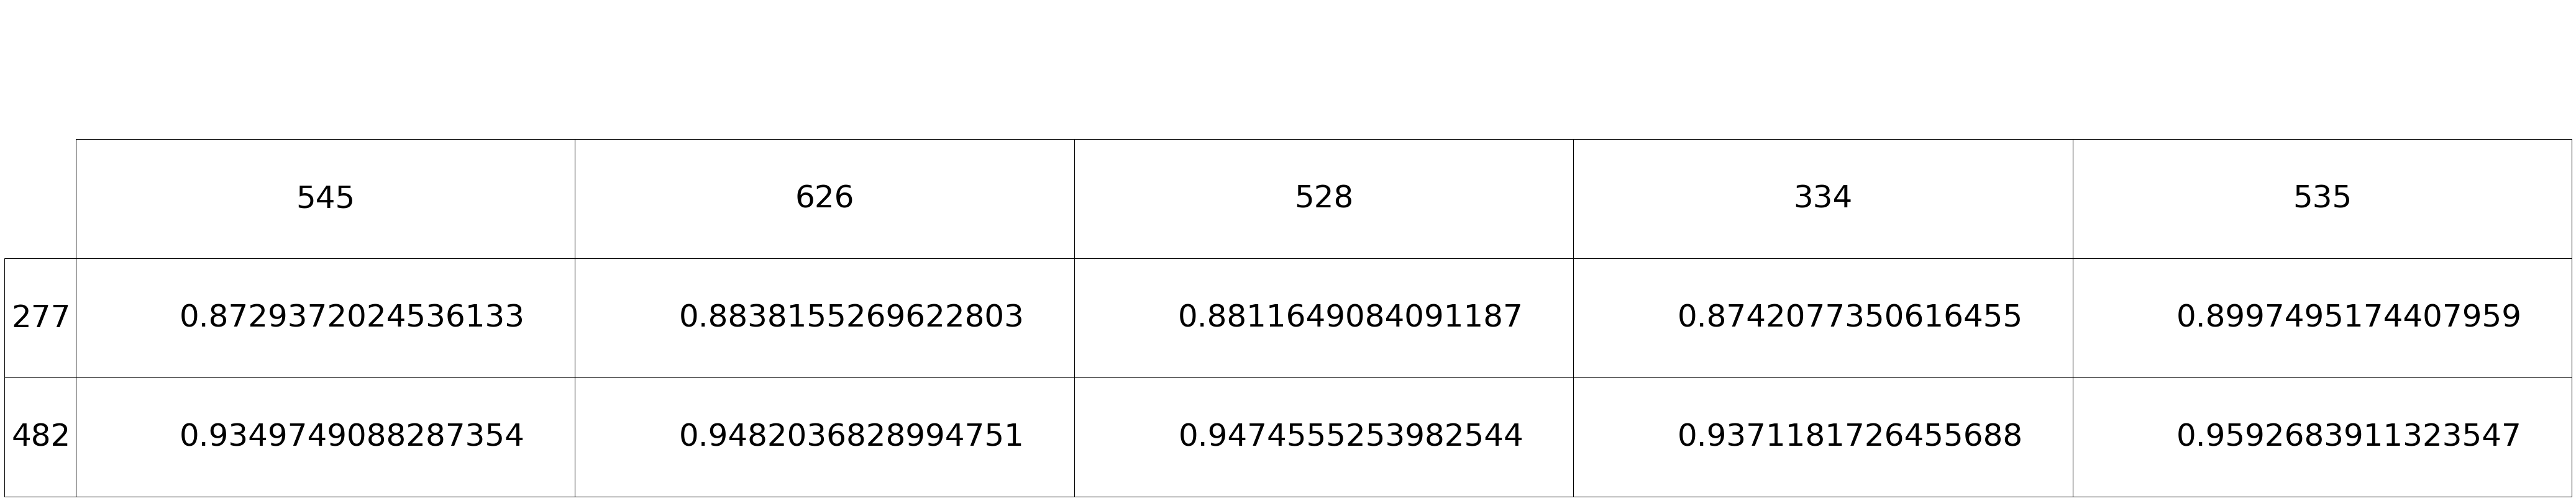


	user_id : 3582


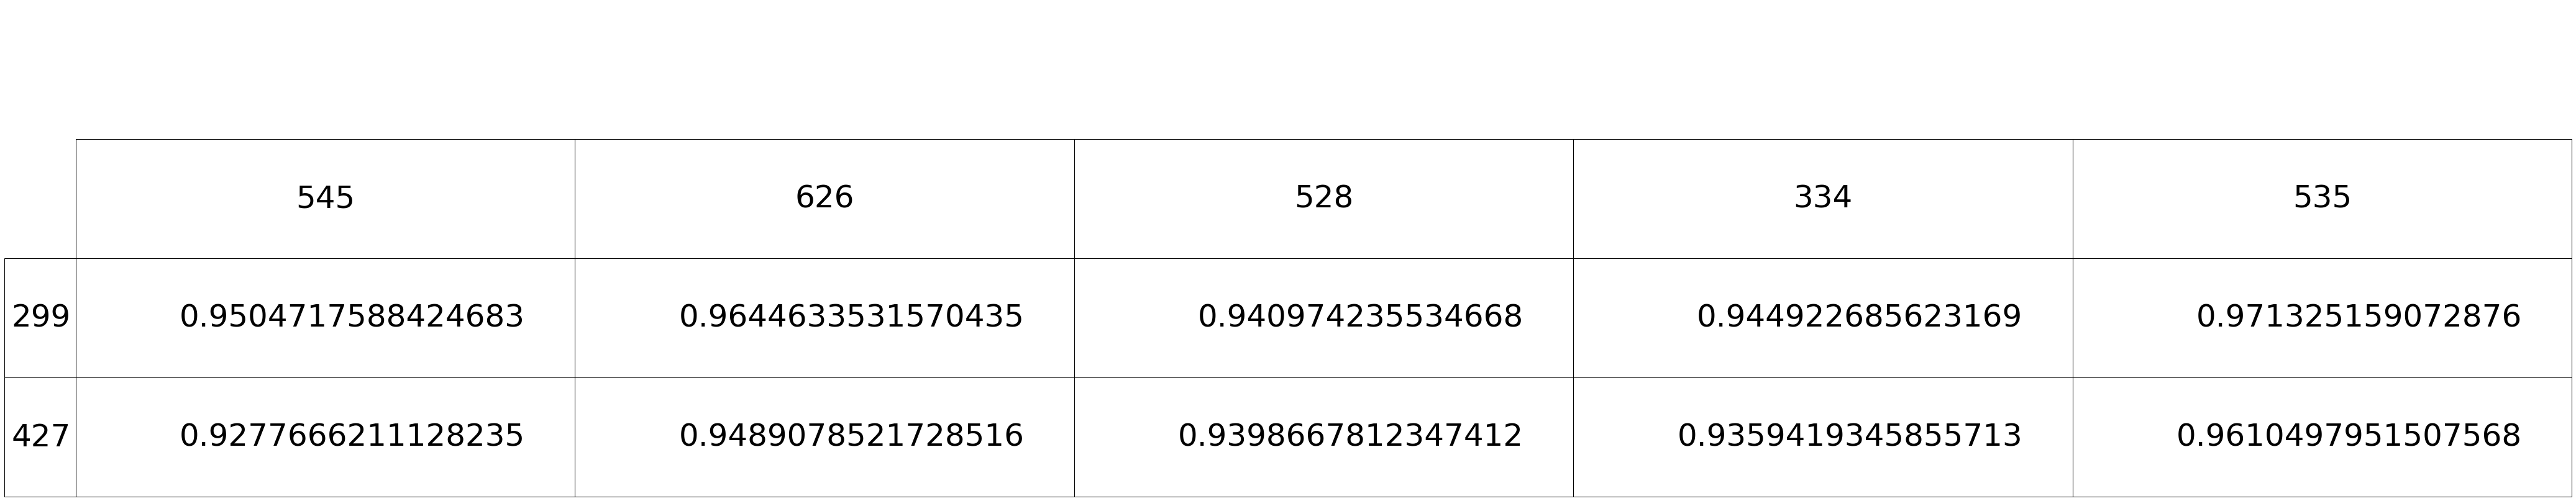


	user_id : 5289


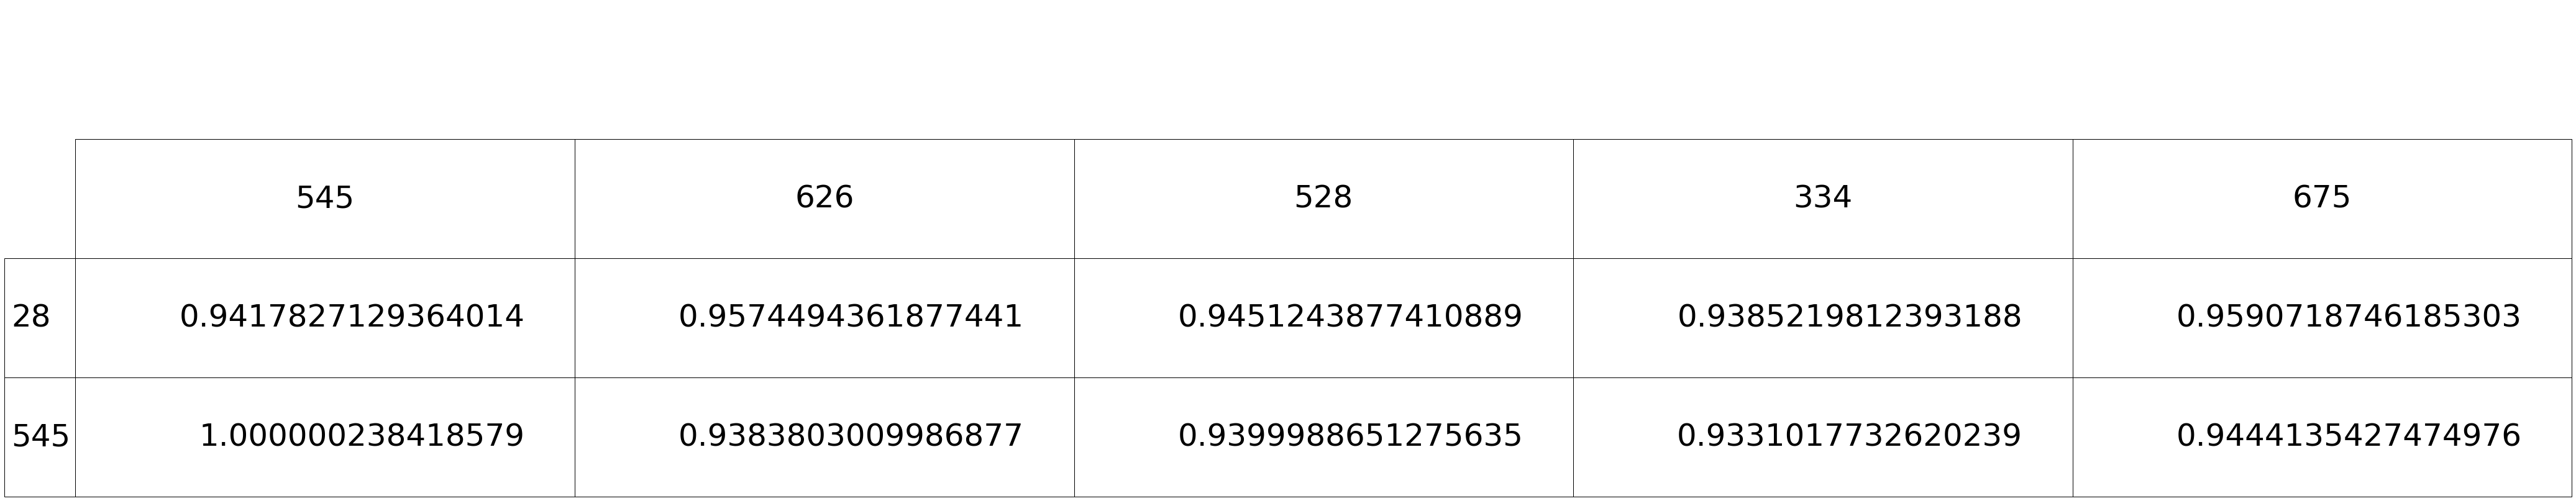


	user_id : 4049


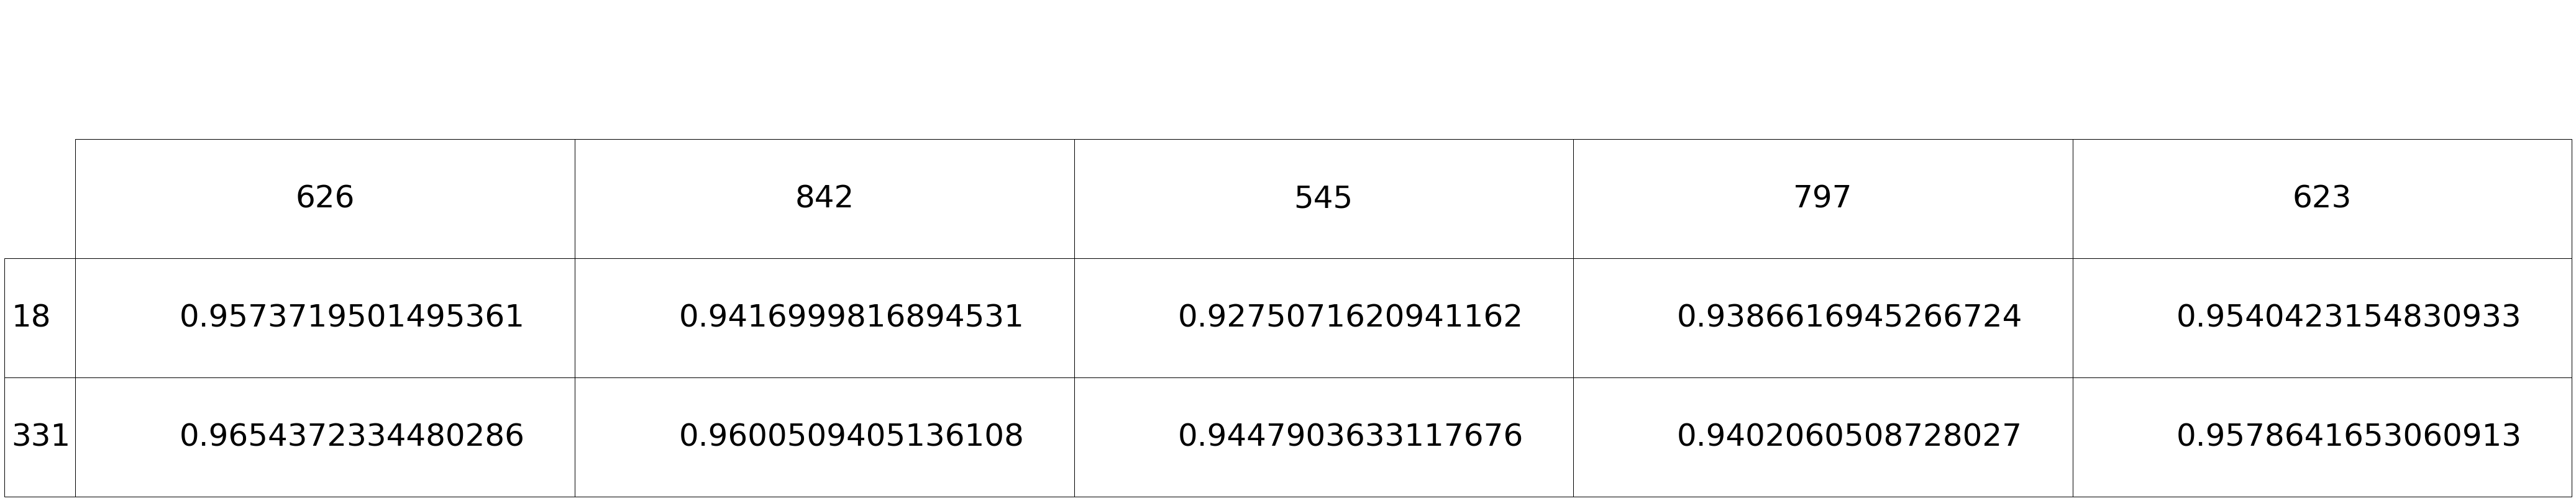


	user_id : 4083


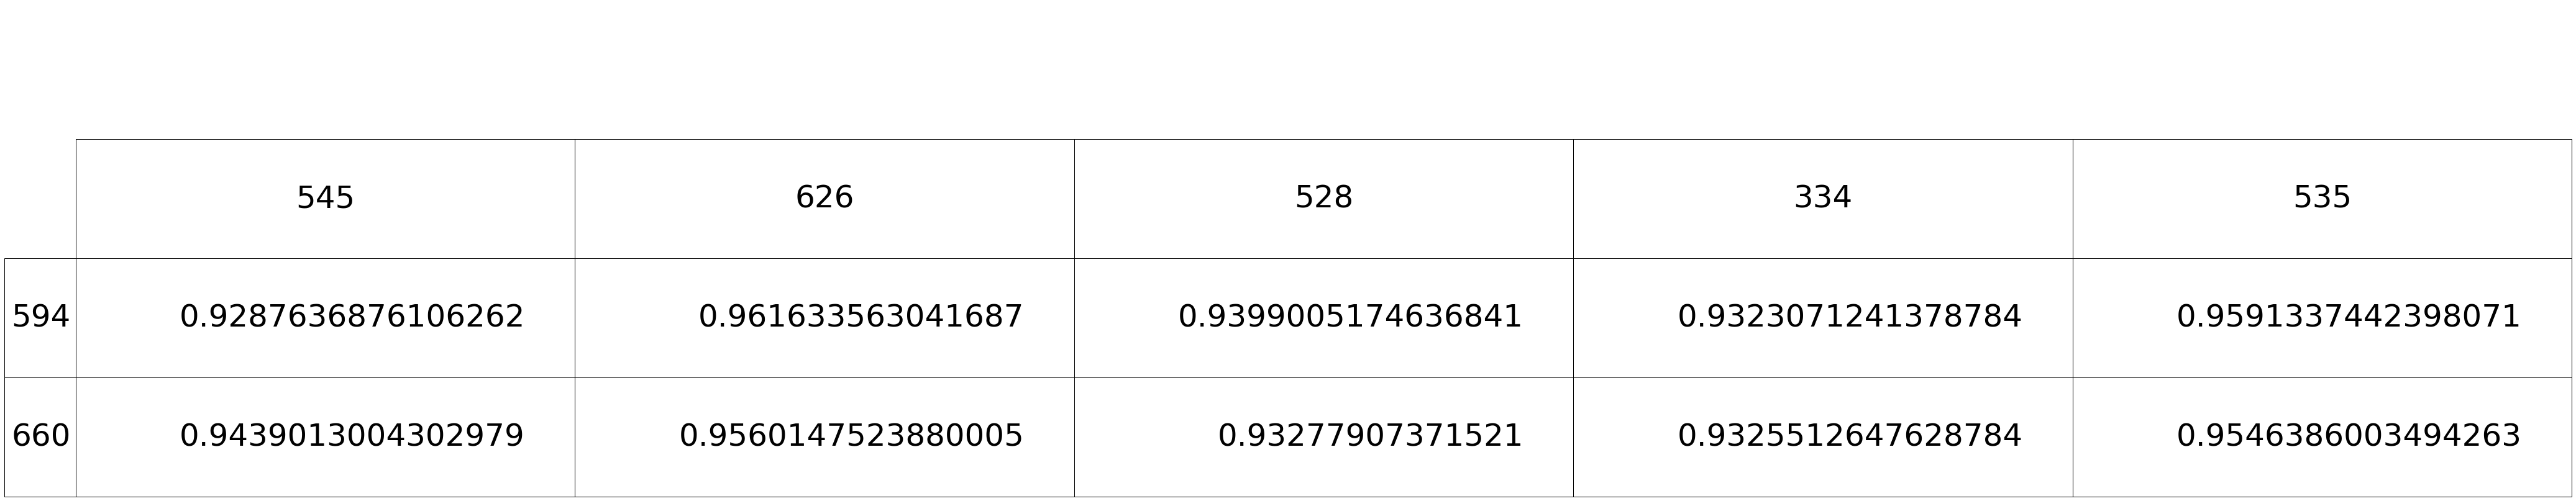


	user_id : 4982


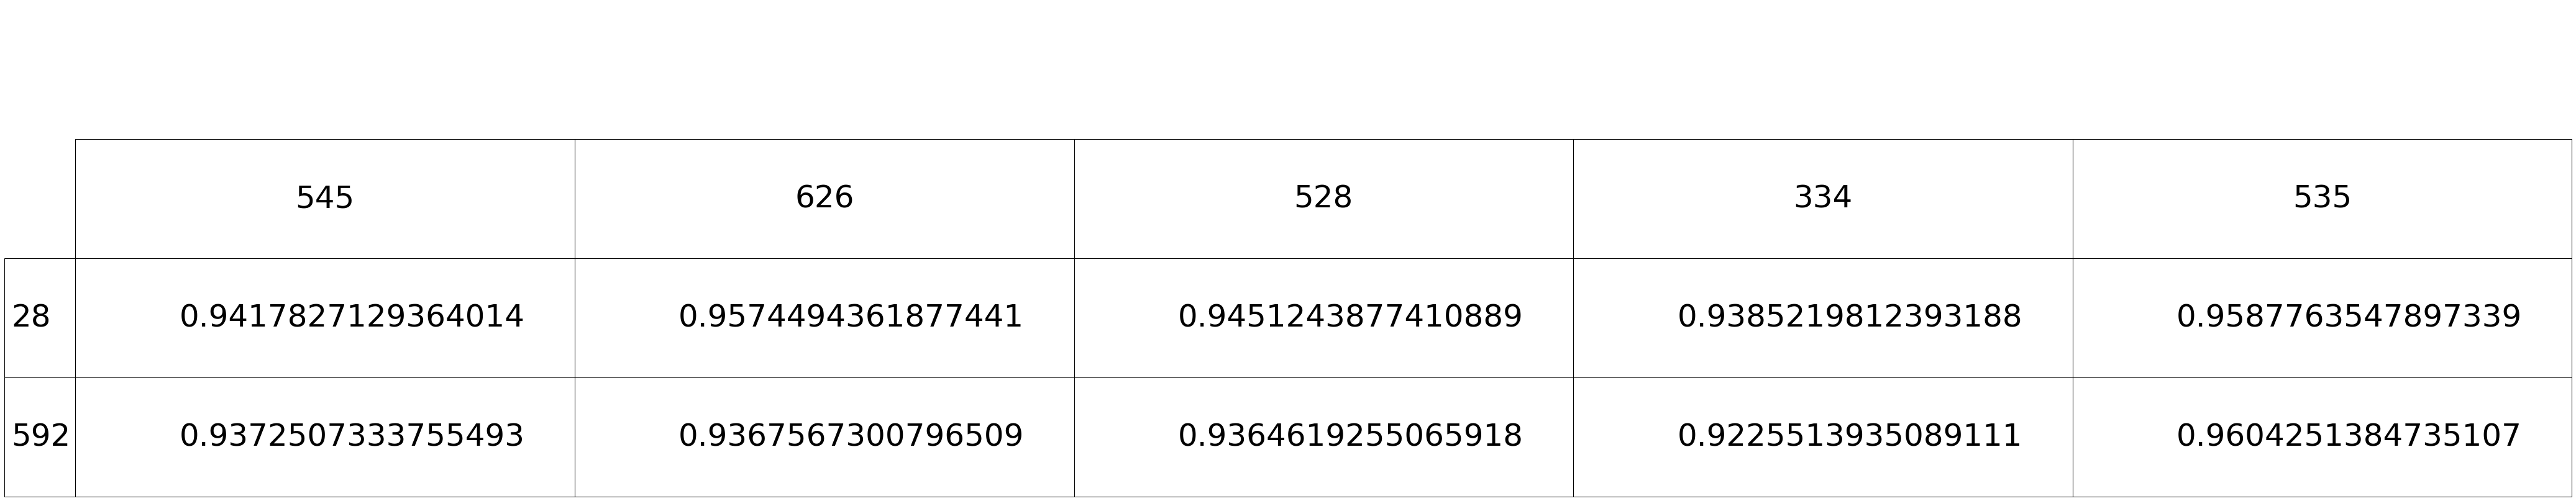


	user_id : 3613


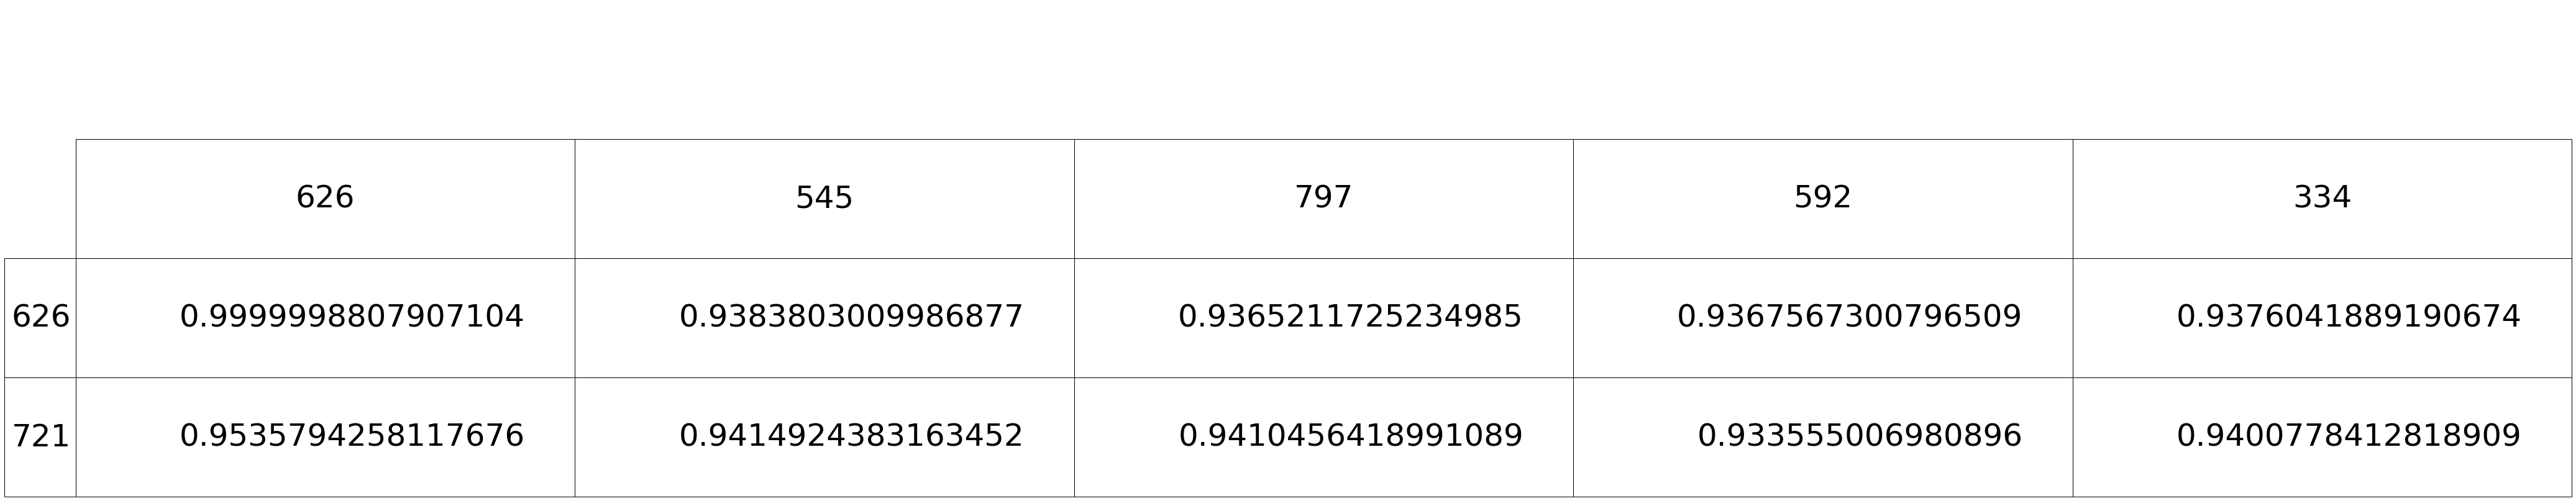


	user_id : 5153


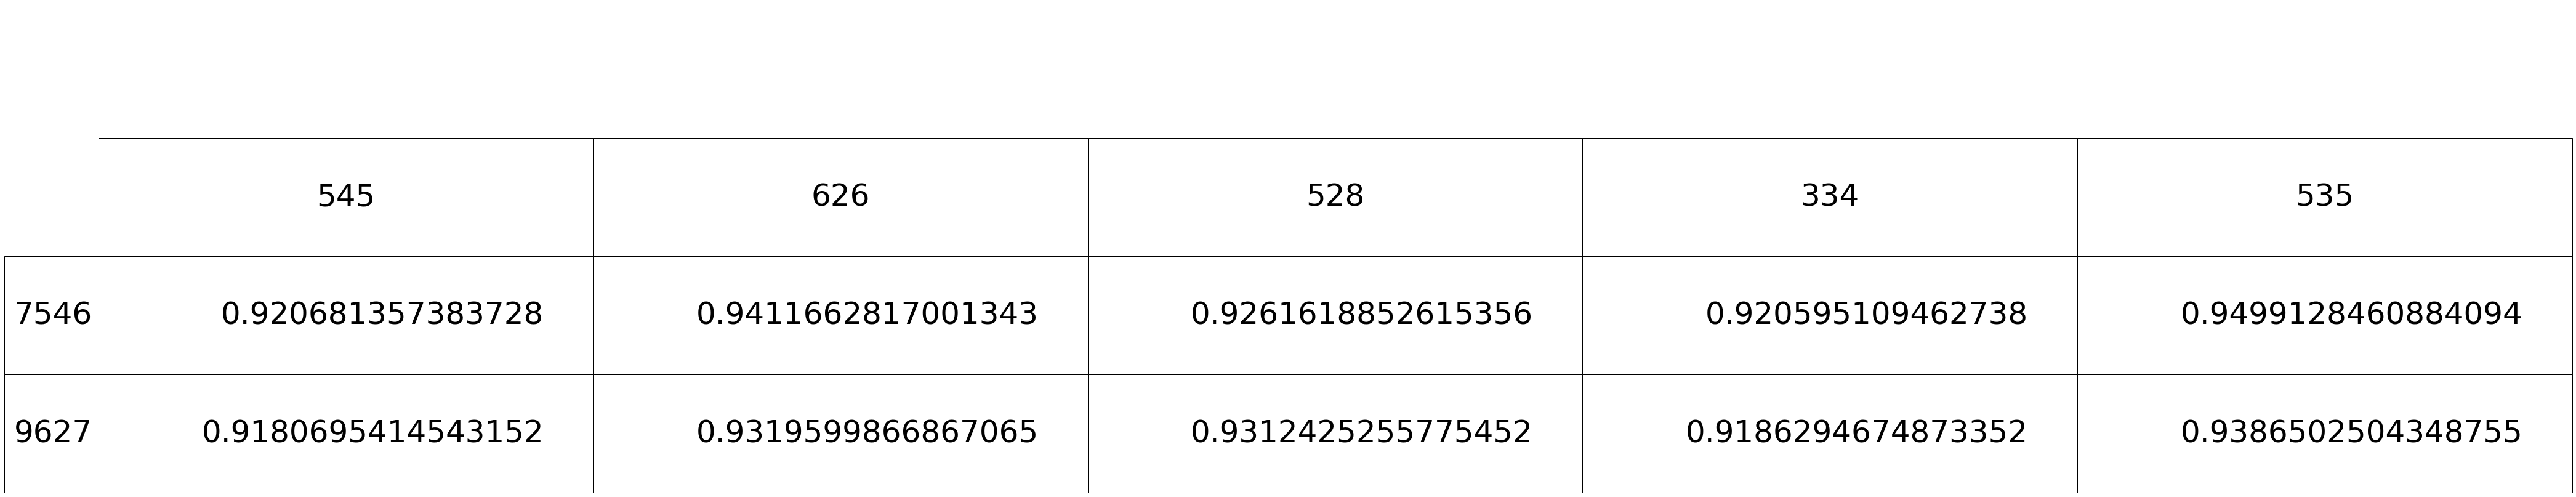


	user_id : 4478


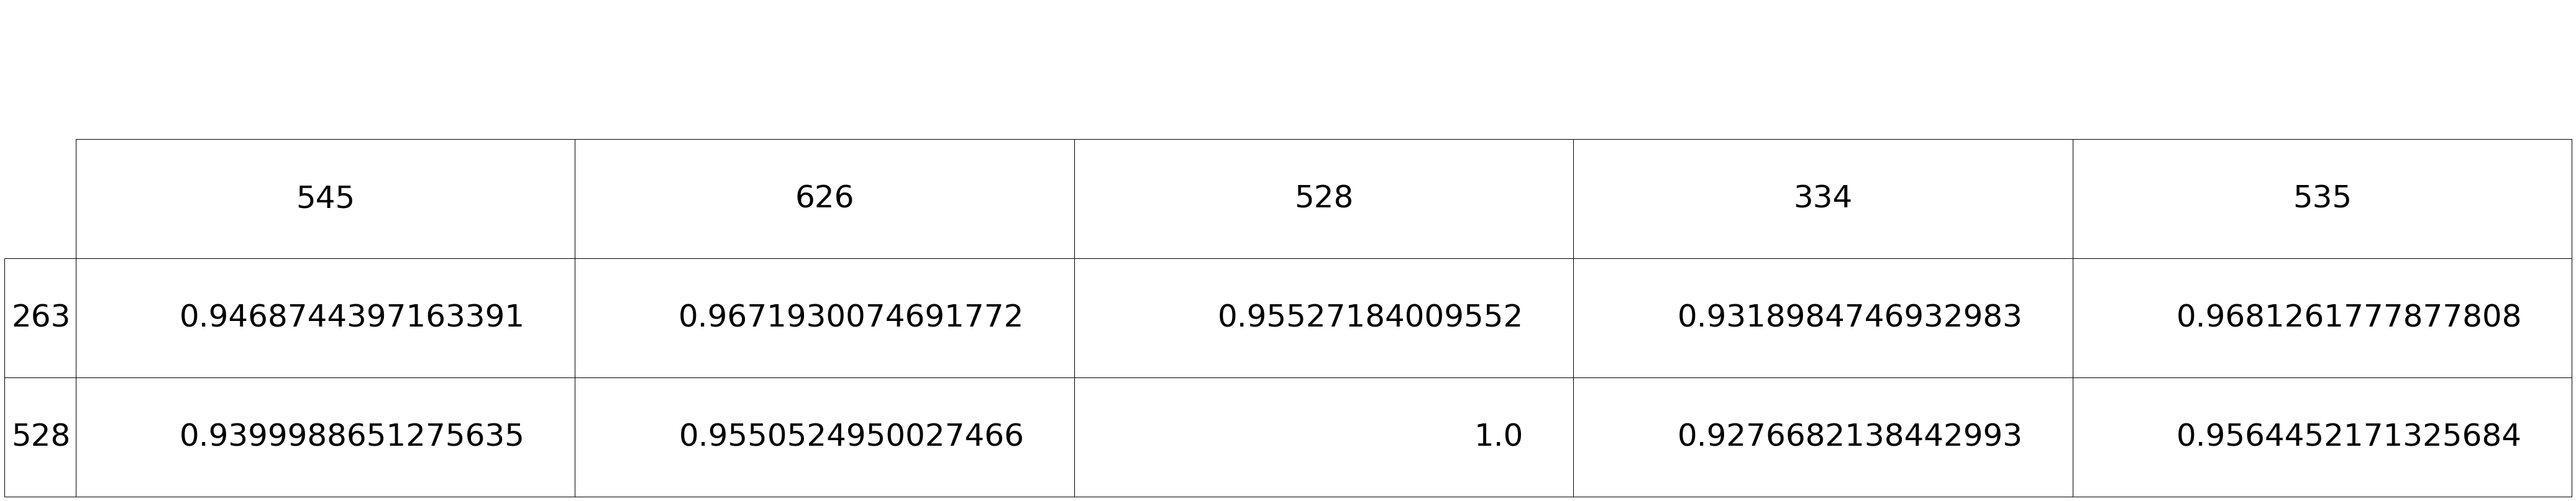


	user_id : 2021


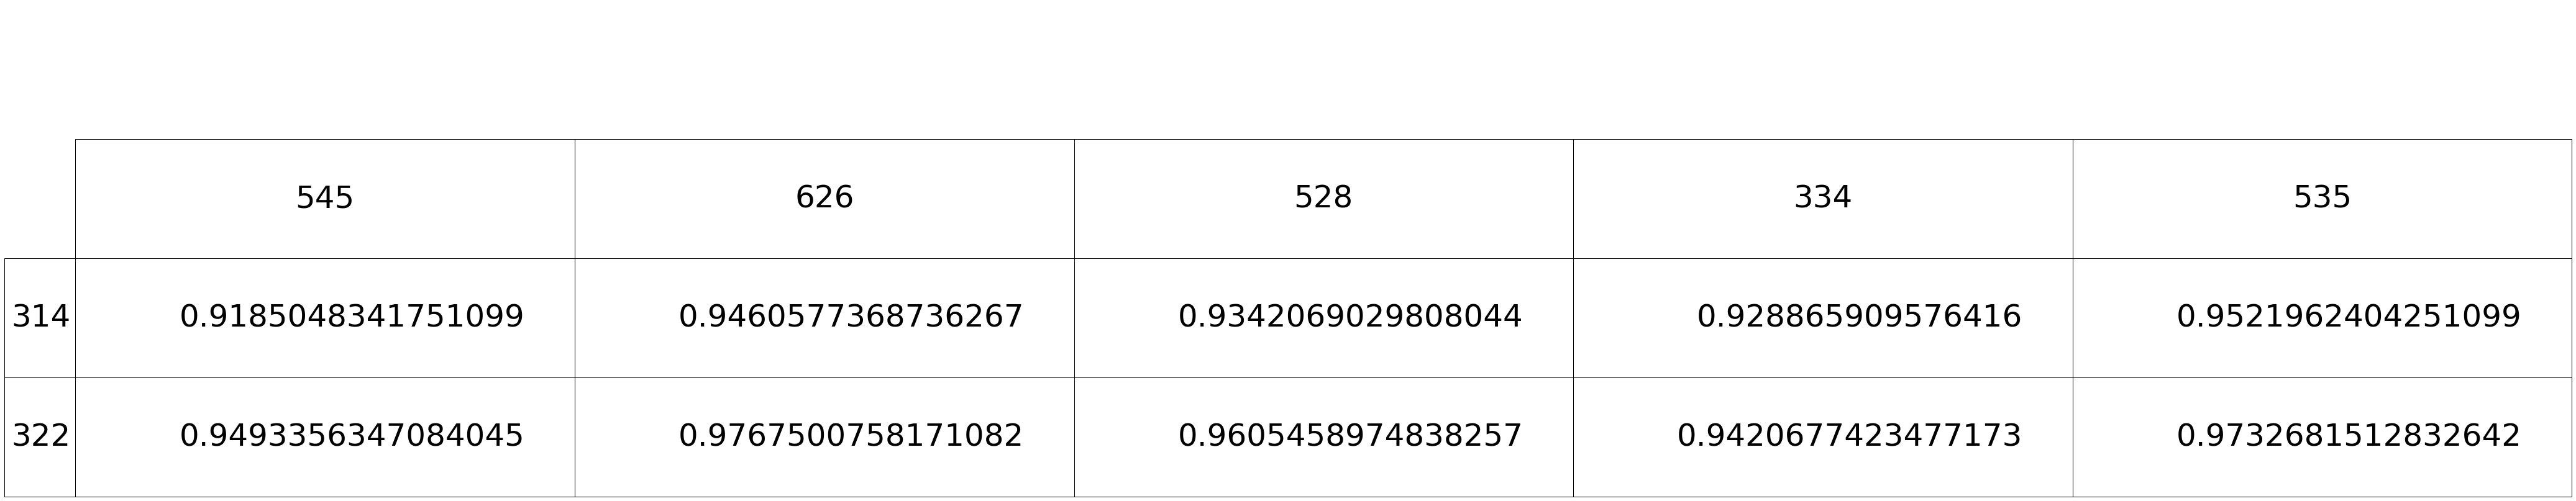


	user_id : 3085


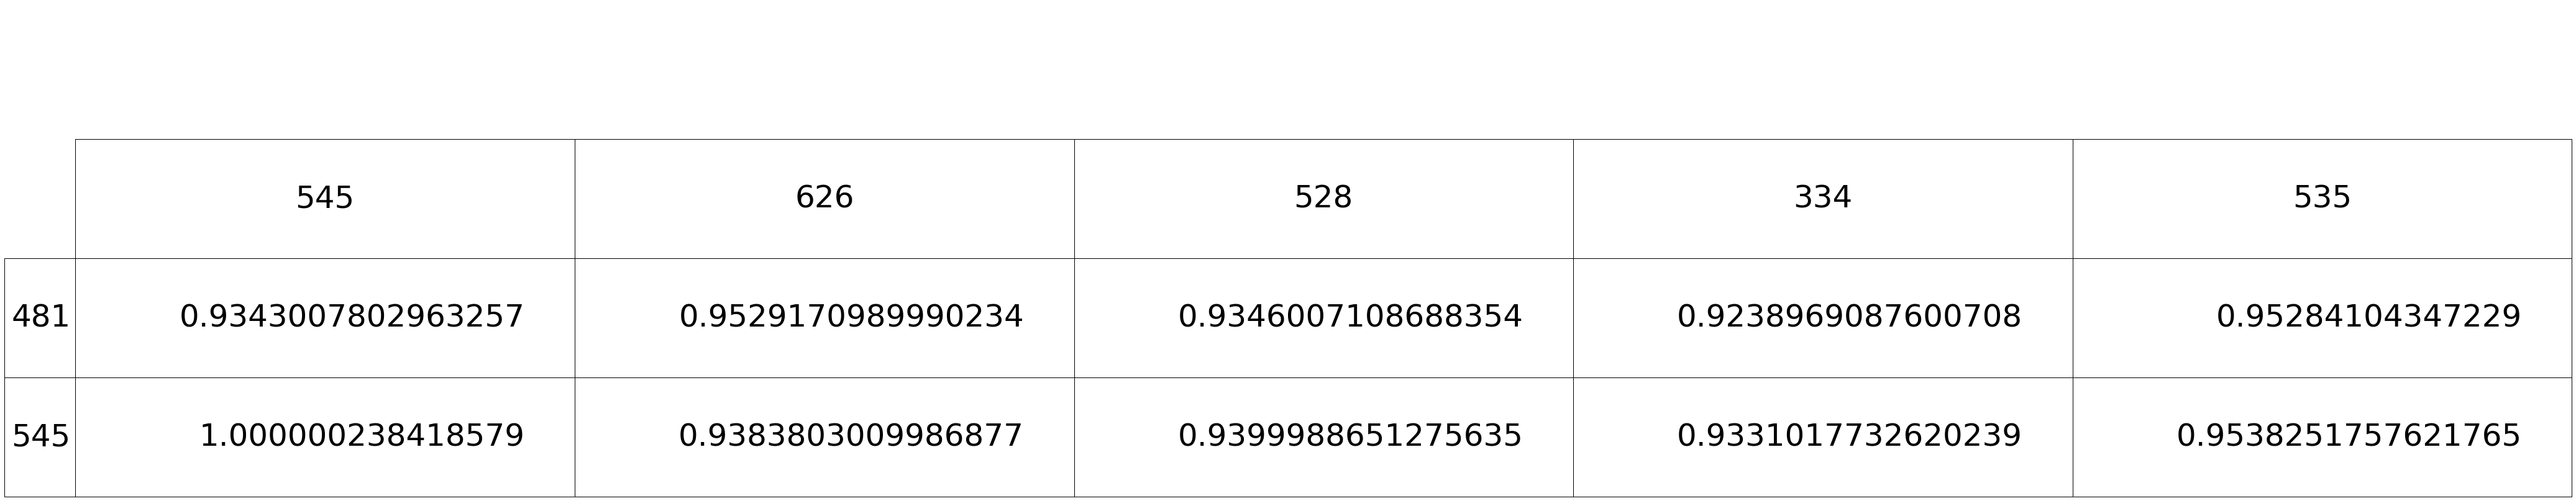

In [34]:
for user_id in data.keys():
    print(f"\n\tuser_id : {user_id}")

    plot_table(user_id)

In [35]:
train_data[train_data[:, 1]==545]

tensor([[               4354,                 545,                   2,
         1572496497000000000],
        [               5289,                 545,                   2,
         1572359346000000000],
        [               2729,                 545,                   3,
         1570716533000000000],
        ...,
        [               3919,                 545,                   3,
         1571819284000000000],
        [               2821,                 545,                   3,
         1570431927000000000],
        [               4636,                 545,                   3,
         1570429028000000000]])

In [36]:
train_data[train_data[:, 1]==626]

tensor([[               5114,                 626,                   2,
         1571066168000000000],
        [               3929,                 626,                   2,
         1570462100000000000],
        [               1777,                 626,                   1,
         1570264321000000000],
        ...,
        [               1359,                 626,                   3,
         1571630685000000000],
        [               3345,                 626,                   3,
         1570340919000000000],
        [               2026,                 626,                   3,
         1570953819000000000]])

In [37]:
train_data[train_data[:, 1]==334]

tensor([[               4392,                 334,                   3,
         1570541682000000000],
        [               1882,                 334,                   3,
         1571214479000000000],
        [               4933,                 334,                   3,
         1571133638000000000],
        ...,
        [               2710,                 334,                   2,
         1571939946000000000],
        [               3986,                 334,                   1,
         1572288956000000000],
        [                941,                 334,                   3,
         1572346702000000000]])

In [38]:
import pandas as pd

In [39]:
data_df = pd.read_csv('dataset/eComm-sample-data2.csv')

In [40]:
data_df.shape

(125534, 13)

In [46]:
data_df[data_df.product_id_num==28]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_1,cat_2,user_id_num,product_id_num
39,1569900631000000000,purchase,1002544,2053013555631882655,electronics.smartphone,apple,464.08,516010934,629d01a1-bc23-4c52-91bc-148db8539f87,electronics,smartphone,1971,28
193,1569910742000000000,cart,1002544,2053013555631882655,electronics.smartphone,apple,464.08,535658024,c746854b-0bf1-406a-9ae0-3687be97f8de,electronics,smartphone,3386,28
226,1569911583000000000,cart,1002544,2053013555631882655,electronics.smartphone,apple,464.08,535658024,62e0f746-a9e6-4036-a3bb-681f233ce675,electronics,smartphone,3386,28
234,1569912274000000000,purchase,1002544,2053013555631882655,electronics.smartphone,apple,464.08,541169797,3530f6bb-a819-4fa0-b621-4c6b018292f4,electronics,smartphone,3654,28
240,1569912722000000000,cart,1002544,2053013555631882655,electronics.smartphone,apple,464.08,541169797,3530f6bb-a819-4fa0-b621-4c6b018292f4,electronics,smartphone,3654,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124721,1572541249000000000,view,1002544,2053013555631882655,electronics.smartphone,apple,458.28,549097564,bbaf0a5a-a6e2-4086-a827-a0c154b7fc54,electronics,smartphone,4196,28
124792,1571054281000000000,view,1002544,2053013555631882655,electronics.smartphone,apple,460.50,523134312,9207af9c-c2db-4e9d-986e-9e088f896f0f,electronics,smartphone,2797,28
124945,1570638613000000000,view,1002544,2053013555631882655,electronics.smartphone,apple,460.62,513340366,ccc480ab-e4b7-4da2-b530-4b5a20b4beda,electronics,smartphone,977,28
125177,1569912708000000000,view,1002544,2053013555631882655,electronics.smartphone,apple,464.08,541169797,3530f6bb-a819-4fa0-b621-4c6b018292f4,electronics,smartphone,3654,28


In [47]:
data_df[data_df.product_id_num.isin([545, 626, 528, 334, 535])]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_1,cat_2,user_id_num,product_id_num
30,1569899683000000000,cart,1004249,2053013555631882655,electronics.smartphone,apple,738.61,517857007,1ea18365-2549-47c6-a562-57c03b8cbb24,electronics,smartphone,2256,334
32,1569899731000000000,purchase,1004249,2053013555631882655,electronics.smartphone,apple,738.61,517857007,1ea18365-2549-47c6-a562-57c03b8cbb24,electronics,smartphone,2256,334
41,1569900773000000000,cart,1004767,2053013555631882655,electronics.smartphone,samsung,254.76,545218213,0fc7e58e-250a-47df-98c9-a054e00c0f59,electronics,smartphone,3912,545
61,1569902987000000000,cart,1004767,2053013555631882655,electronics.smartphone,samsung,254.76,516489628,39db535f-cfba-4412-8774-453645669a0b,electronics,smartphone,2069,545
62,1569903013000000000,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,254.76,516489628,39db535f-cfba-4412-8774-453645669a0b,electronics,smartphone,2069,545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125452,1572001933000000000,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,189.97,557746959,499fdce6-c287-421b-9382-e6ebf7a878c8,electronics,smartphone,4934,528
125459,1571935525000000000,view,1004873,2053013555631882655,electronics.smartphone,samsung,369.20,551054292,3f6d59e7-9a36-4af8-9e50-2848edada0cc,electronics,smartphone,4329,626
125466,1570347092000000000,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,190.91,543356214,e3168804-1b7b-451d-a4bb-24da042c97ee,electronics,smartphone,3804,528
125501,1570185450000000000,view,1004767,2053013555631882655,electronics.smartphone,samsung,252.83,535568683,34cb3dad-4b86-4553-bec2-31f02b711e4d,electronics,smartphone,3381,545
